# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [3]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [4]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [5]:
def norm_filter(adata, mito_genes, RB_genes_in_data
                , log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [6]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [7]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('../DEA/' + cell_type):
        os.makedirs('../DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)
    
    expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [8]:
def run_MAST_for_celltype_condition(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST_condition.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file )
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [9]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [10]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [12]:
adata_astro = sc.read_h5ad(outdir+'adata_high_var_Astro_diff_norm_clusters.h5ad')

# Subset Astrocytes Brainstem & Input original Adata

In [13]:
adata_astro_BS = adata_astro.copy()
adata_astro_BS = adata_astro_BS[adata_astro_BS.obs['B_region'].isin(['BrainStem']),:]
adata_astro_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1039, 12353)

In [14]:
adata_astro_BS.obs.Condition.value_counts()

VE         550
Control    489
Name: Condition, dtype: int64

In [15]:
broad_clusters = adata_astro_BS.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_astro_BS.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 489})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 550})


In [16]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [17]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [18]:
adata_astro_BS = adata[adata_astro_BS.obs.index, :]
adata_astro_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1039, 22292)

# Pre-processing

## QC

In [19]:
adata_astro_BS, mito_genes, RB_genes_in_data = qc_metrics(adata_astro_BS)
markers = []
if type(adata_astro_BS.X)==np.ndarray:
    pass
else:
    print(type(adata_astro_BS.X))
    #print(adata_norm.X.shape)
    adata_astro_BS.X = adata_astro_BS.X.toarray()
    #print(adata_norm.X.shape)
adata_astro_BS.X = pd.DataFrame(data=adata_astro_BS.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [20]:
adata_astro_BS.shape

(1039, 22292)

## Normalization

In [21]:
markers = []
adata_astro_BS, markers = norm_filter(adata_astro_BS, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_astro_BS.obs.head()

(1039, 22292)
(1039, 11751)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1039, 11581)
(1039, 11569)
True
Im here2


Trying to set attribute `.uns` of view, copying.


1999
1999


Sample ID  \
cell_barcodes                                                                          
227295685654444_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7          1822_996_VE_ES_BS_IGO_10875_7   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3  1820_C1029_Ctrl_ES_BS_IGO_10856_3   

                                                  Condition   B_region  \
cell_barcodes                                                            
227295685654444_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7            VE  BrainStem   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  BrainStem   

                                                   n_genes_by_counts  \
cell_barcodes                                                          
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                   1399   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1874   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                   1153   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1466   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3               1614   

                                                   log1p_n_genes_by_counts  \
cell_barcodes                                                                
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                     7.244228   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.536364   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                     7.050989   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.290975   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3                 7.387090   

                                                   total_counts  \
cell_barcodes                                                     
227295685654444_1822_996_VE_ES_BS_IGO_10875_7            2340.0   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3        3414.0   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7            1810.0   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3        2724.0   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3        3144.0   

                                                   log1p_total_counts  \
cell_barcodes                                                           
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                7.758334   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3            8.135933   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                7.501635   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3            7.910223   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3            8.053569   

                                                   pct_counts_in_top_50_genes  \
cell_barcodes                                                                   
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                       22.606838   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   20.767428   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                       23.756906   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   23.421439   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3                   25.858779   

                                                   pct_counts_in_top_100_genes  \
cell_barcodes                                                                    
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                        30.726496   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    28.529584   
121887371

## PCA

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1039, 11569)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


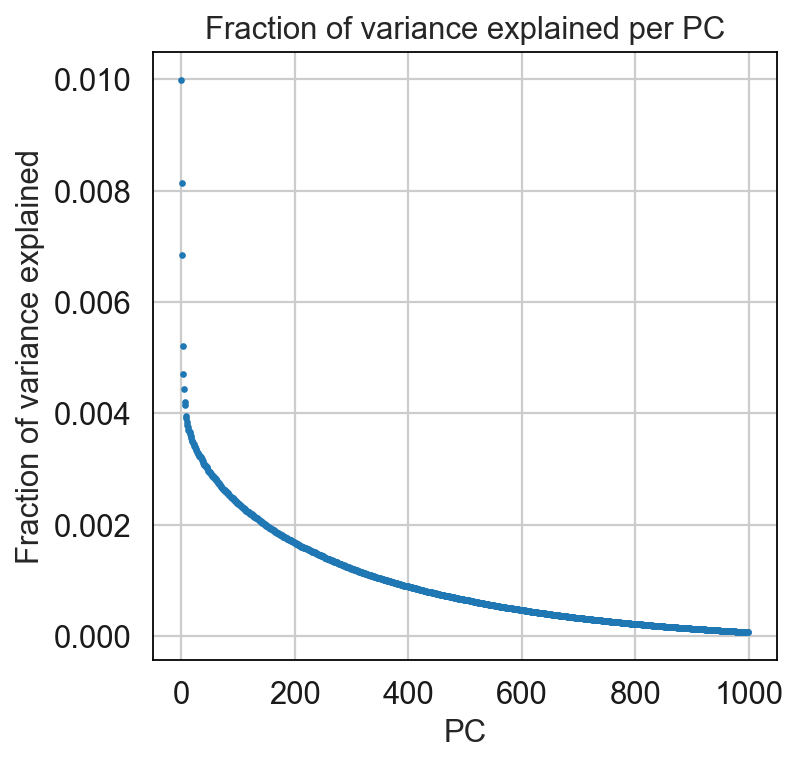

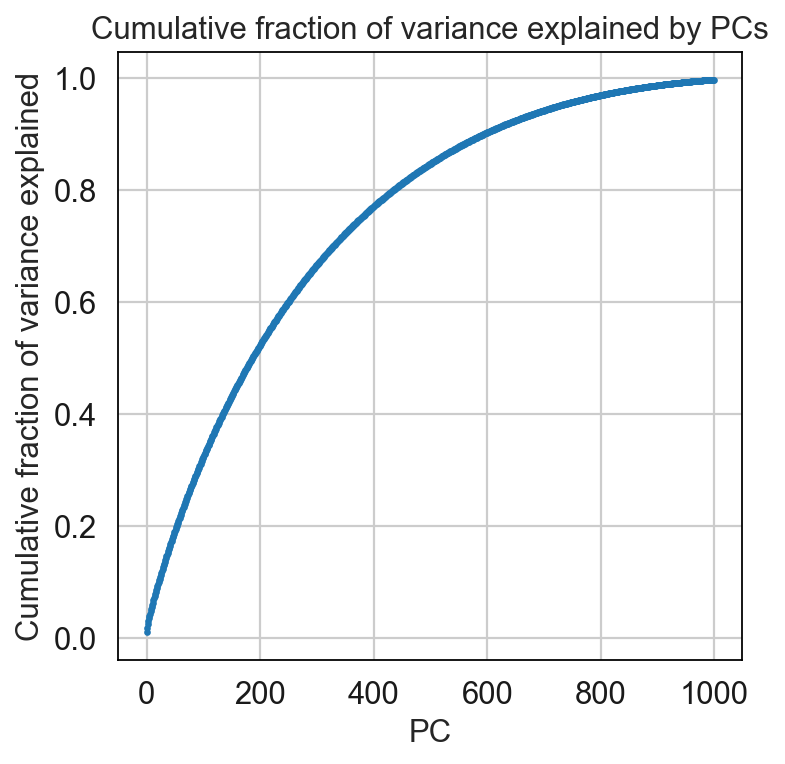

Knee point: 97
Explained variance: 0.316608


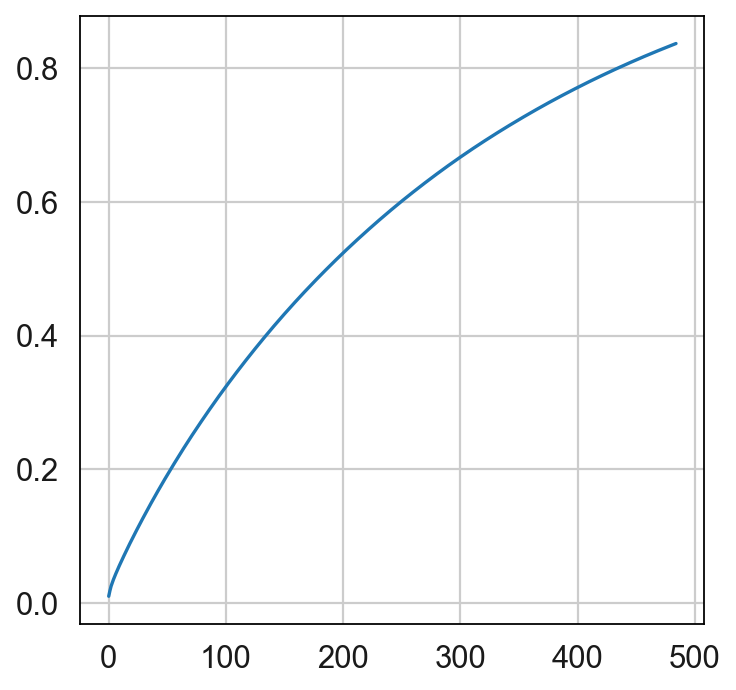

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


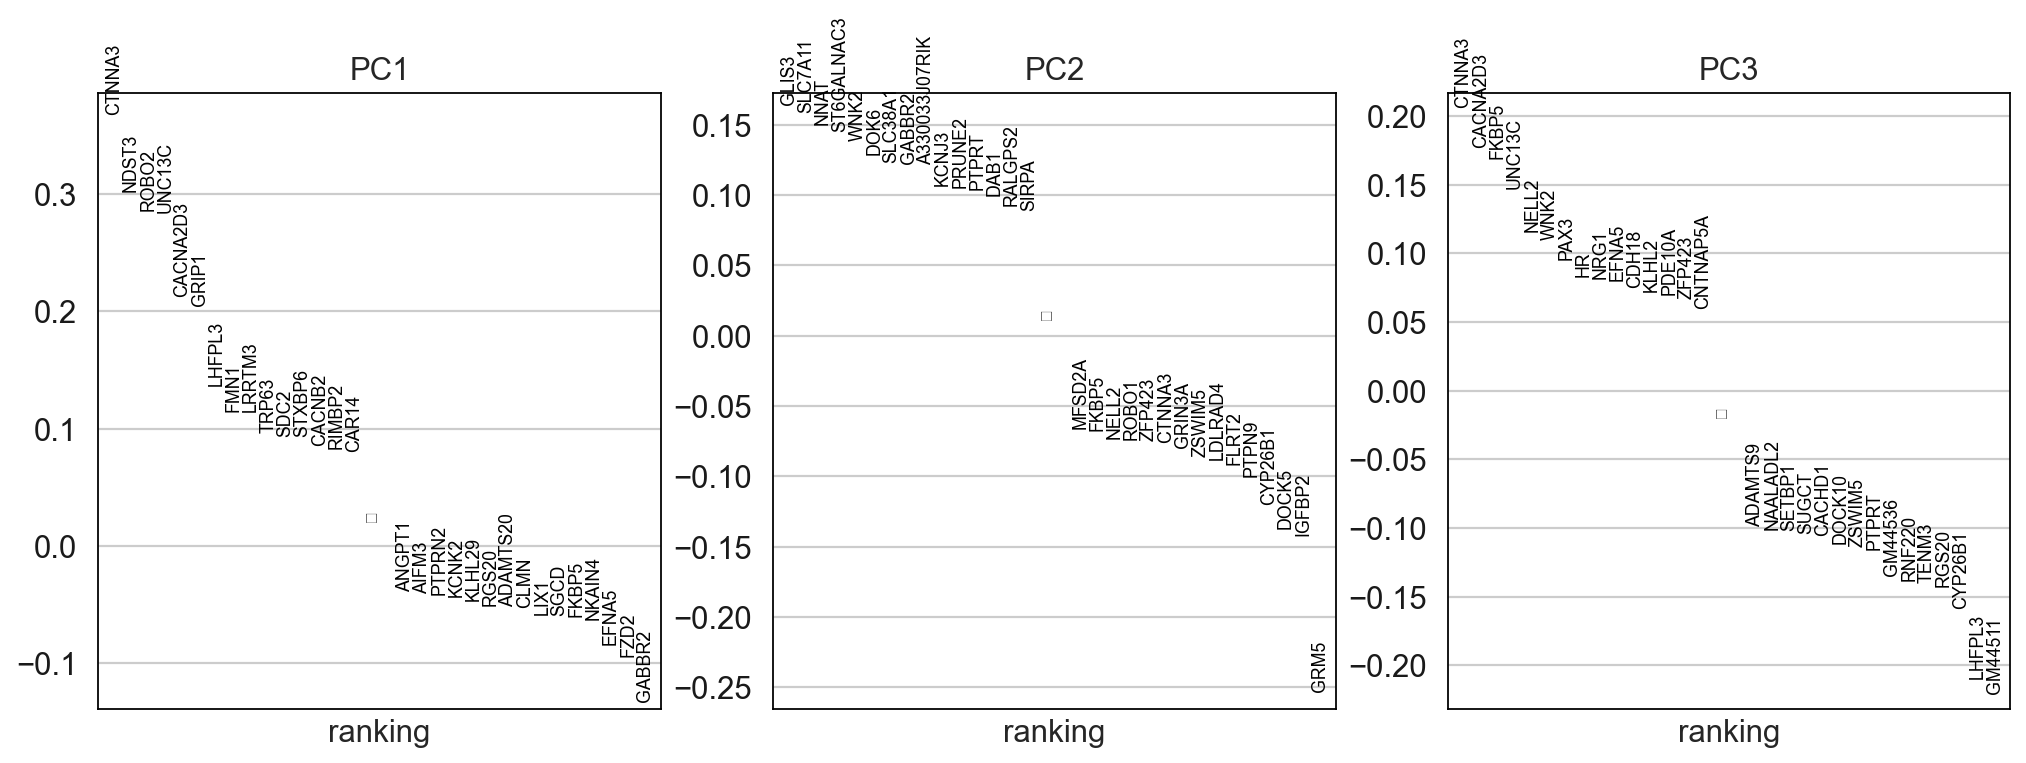

(1039, 11569)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
sc.set_figure_params(figsize=(5, 5))
adata_astro_BS = run_pca_knee(adata_astro_BS)#, 0.5)
adata_astro_BS.obs['PC 1'] = adata_astro_BS.obsm['X_pca'][:,0] # optional
adata_astro_BS.obs['PC 2'] = adata_astro_BS.obsm['X_pca'][:,1]
adata_astro_BS.obs['PC 3'] = adata_astro_BS.obsm['X_pca'][:,2]

print(adata_astro_BS.shape)
adata_astro_BS.X = pd.DataFrame(adata_astro_BS.X).fillna(0).values
index_list = np.arange(adata_astro_BS.shape[0])
np.random.shuffle(index_list)
adata_astro_BS = adata_astro_BS[index_list,:]

In [23]:
print(adata_astro_BS.shape)
adata_astro_BS.X = pd.DataFrame(adata_astro_BS.X).fillna(0).values
index_list = np.arange(adata_astro_BS.shape[0])
np.random.shuffle(index_list)
adata_astro_BS = adata_astro_BS[index_list,:]

(1039, 11569)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08883905410766602 seconds
Jaccard graph constructed in 2.095245122909546 seconds
Wrote graph to binary file in 0.013859272003173828 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.461453
Louvain completed 21 runs in 0.4352858066558838 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.3398680686950684 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0423579216003418 seconds
Jaccard graph constructed in 0.9323329925537109 seconds
Wrote graph to binary file in 0.1340007781982422 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.357287
After 2 runs, maximum modularity is Q = 0.361641
After 4 runs, maximum modularity is Q = 0.364707
After 13 runs, maximum modularity is Q = 0.366373
After 30 runs, maximum modularity is Q = 0.370152
Louvain completed 50 runs in 1.1352641582489014 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.0199429988861084 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.05256390571594238 seconds
Jaccard graph constructed in 1.122079849243164 seconds
Wrote graph to binary file in 0.0373377799987793 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.326489
Aft

Text(0.5, 0, 'k')

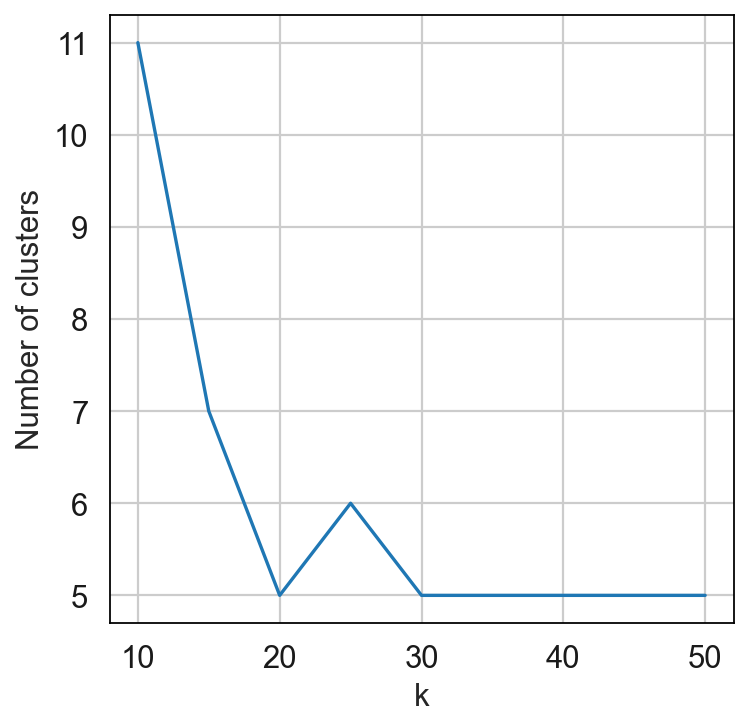

In [24]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro_BS.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_astro_BS.obs['PhenoGraph_clusters_astro_BS'+str(k)] = pd.Categorical(communities)
    adata_astro_BS.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_astro_BS.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [25]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_astro_BS.obs['PhenoGraph_clusters_astro_BS'+str(k_list[run1])].values,
            adata_astro_BS.obs['PhenoGraph_clusters_astro_BS'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

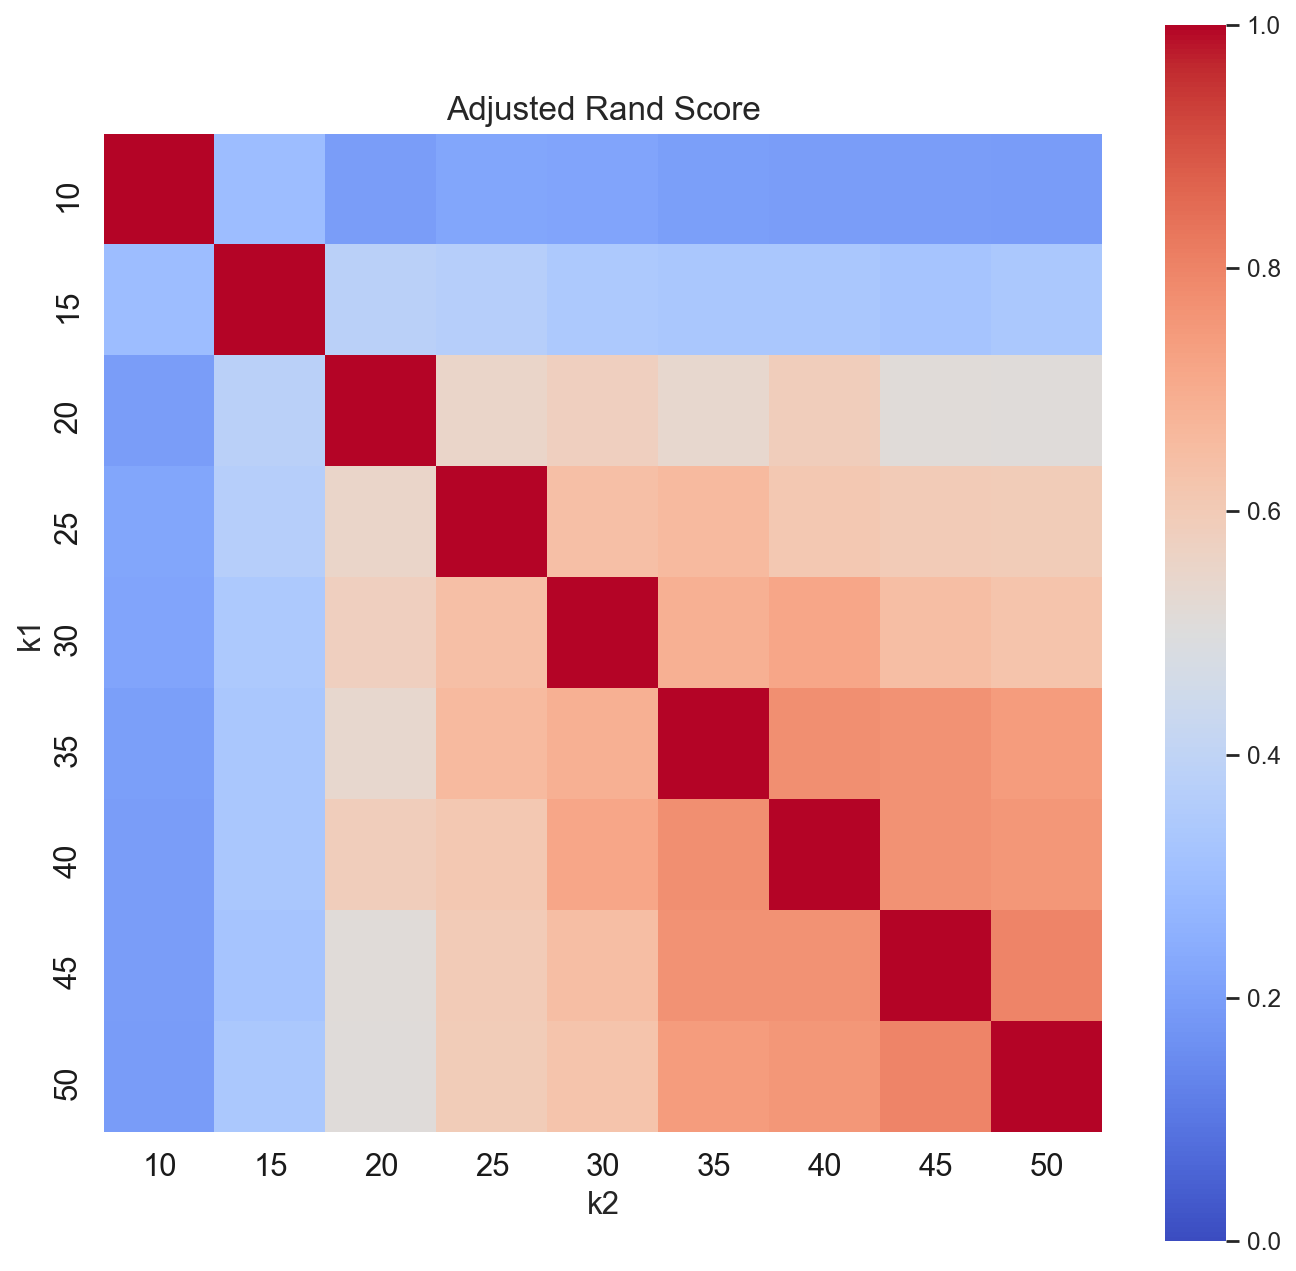

In [26]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [56]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro_BS.obsm['X_pca']),k=k) # run PhenoGraph
adata_astro_BS.obs['PhenoGraph_clusters_astro_BS'] = pd.Categorical(communities)
adata_astro_BS.uns['PhenoGraph_Q'] = Q
adata_astro_BS.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.049851179122924805 seconds
Jaccard graph constructed in 2.5062670707702637 seconds
Wrote graph to binary file in 0.10089683532714844 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.267988
Louvain completed 21 runs in 0.6326799392700195 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.943430185317993 seconds


# Vizualization & Markers

## Vizualize Astro BS sub-clusters

In [186]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_astro_BS, method='umap', use_rep='X_pca')
sc.tl.umap(adata_astro_BS, random_state=None)

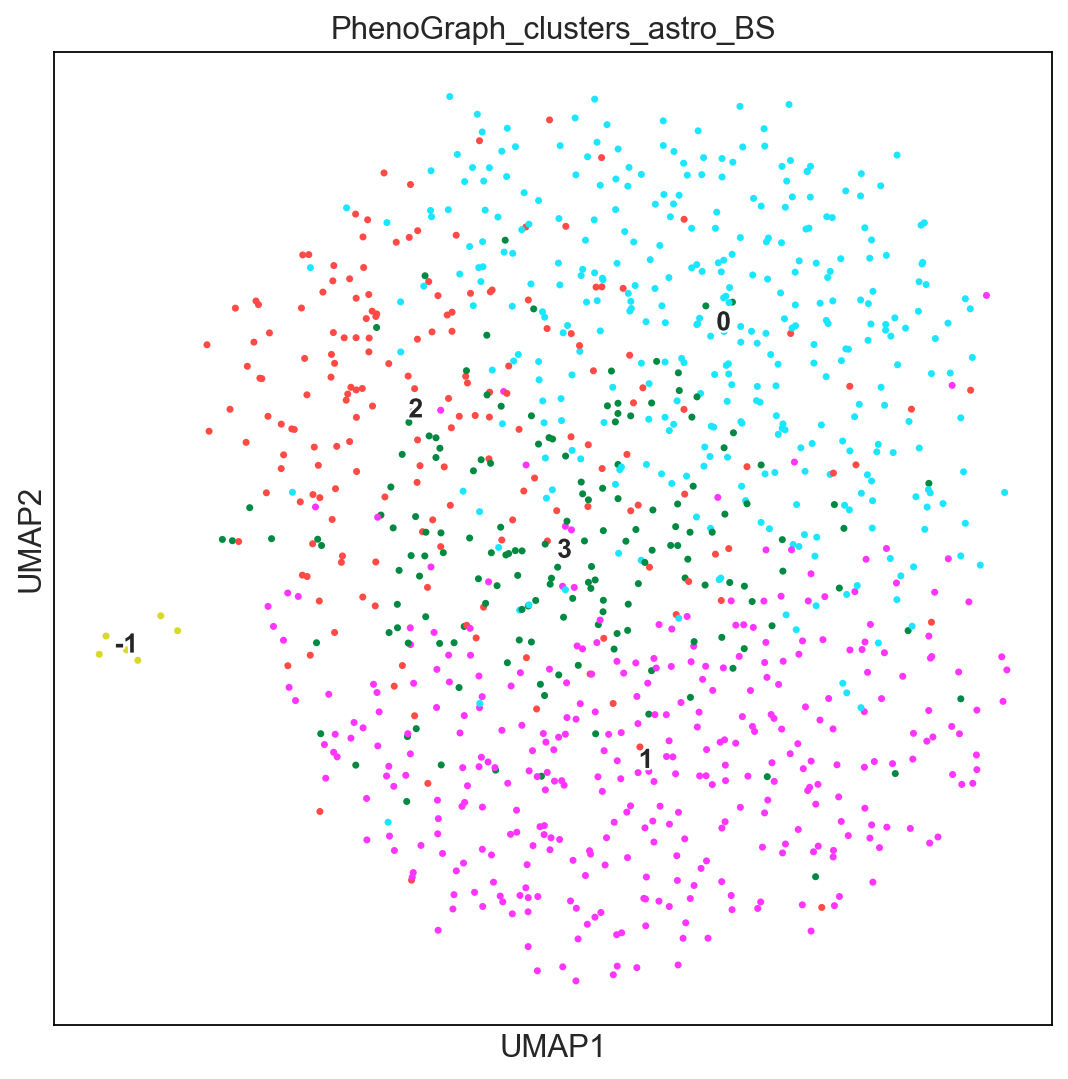

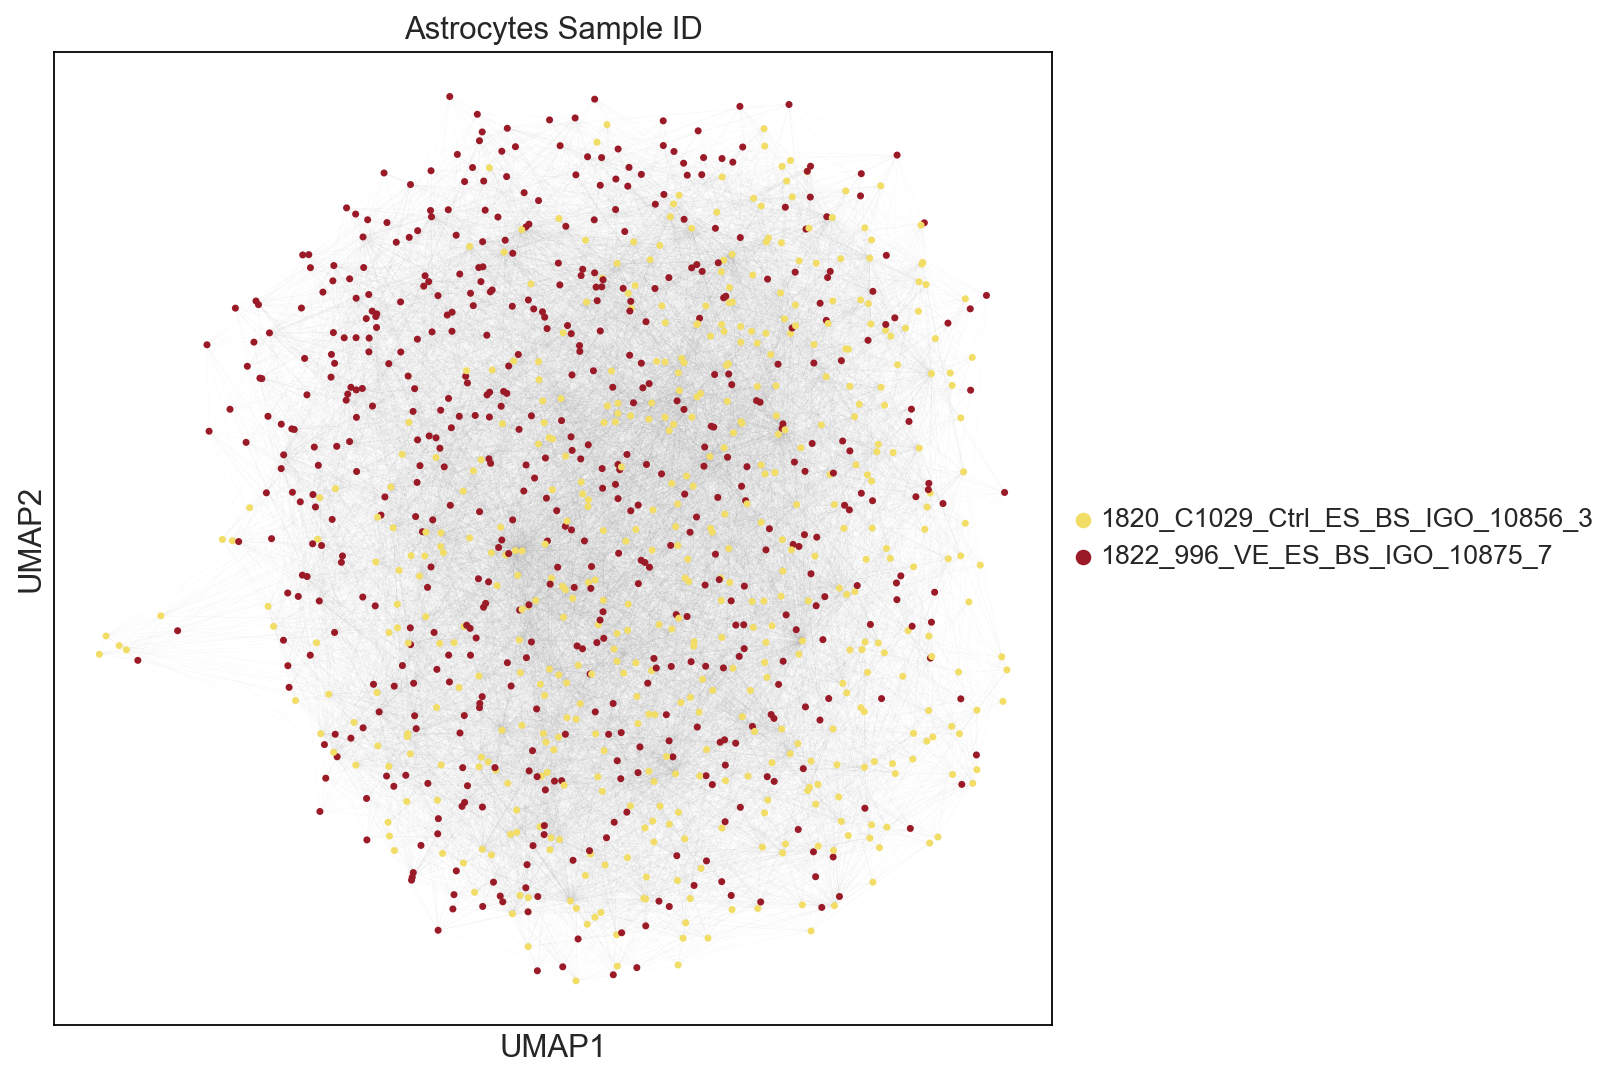

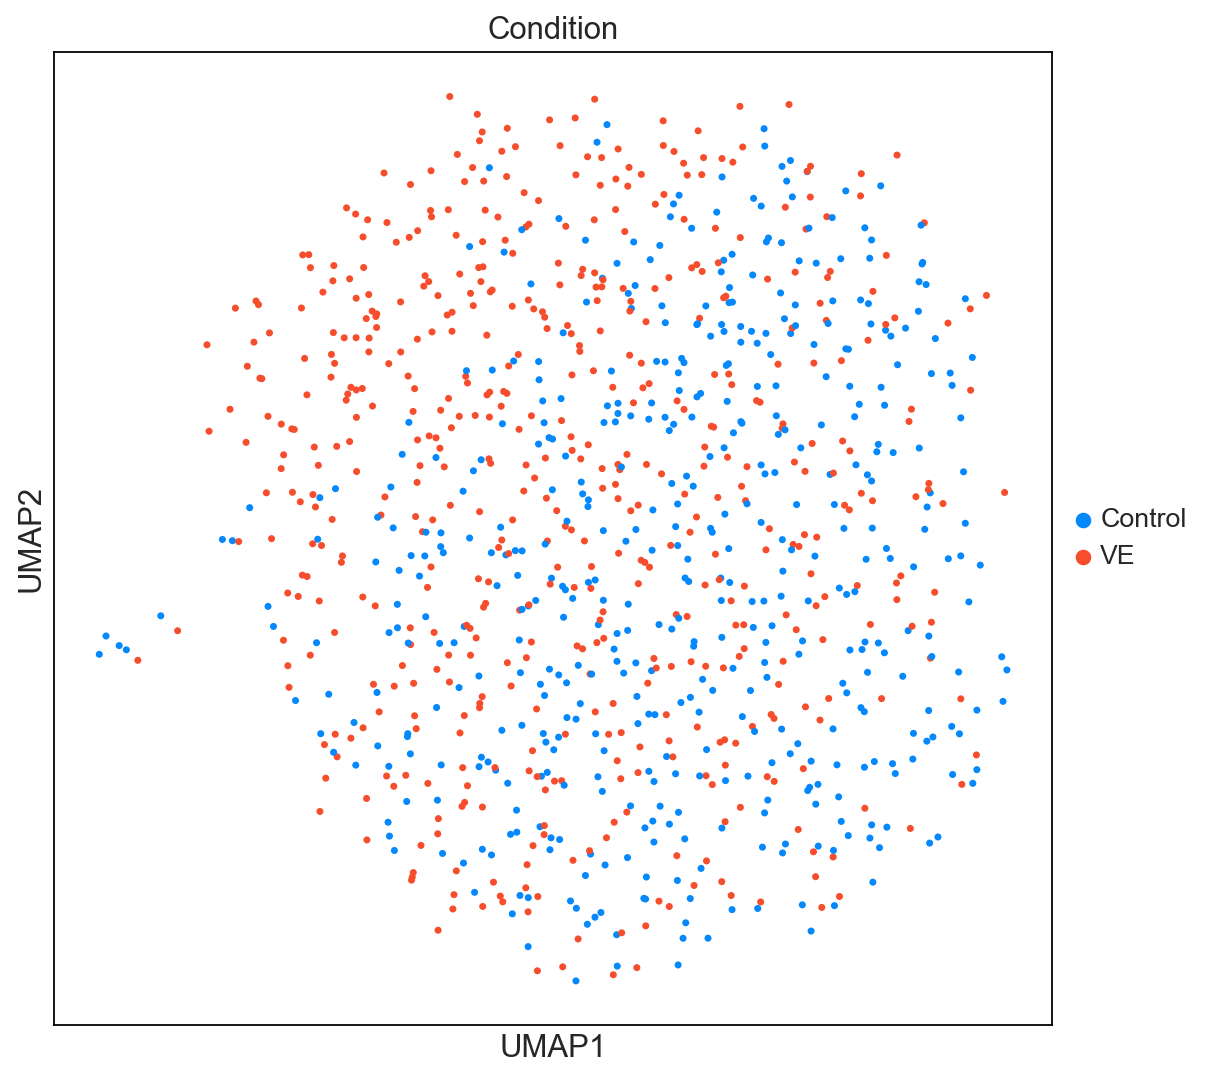

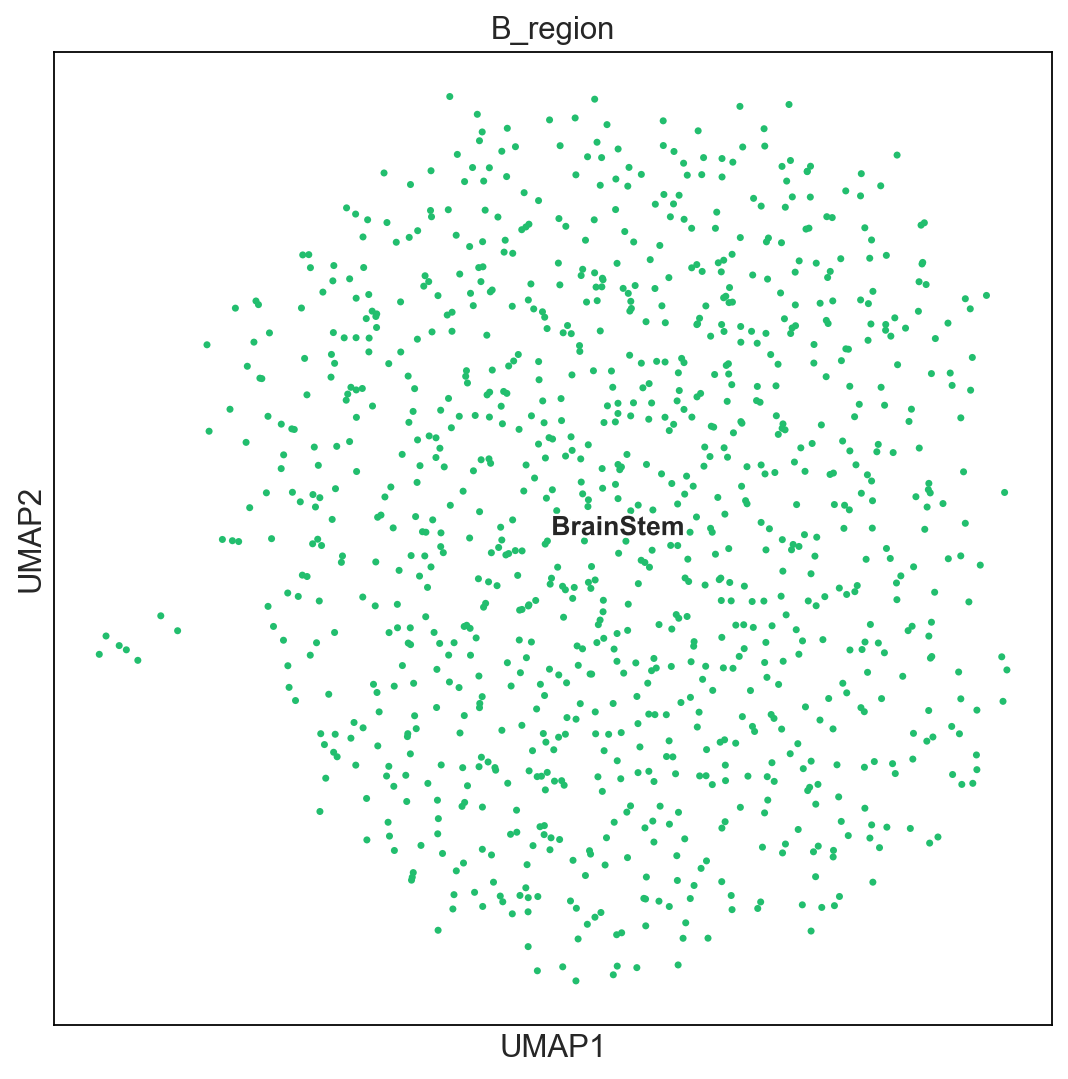

In [187]:
sc.pl.umap(adata_astro_BS,
           color=['PhenoGraph_clusters_astro_BS'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2,)

sc.pl.umap(adata_astro_BS, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=40, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_astro_BS,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)

sc.pl.umap(adata_astro_BS,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 40,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [188]:
cl_int_to_str = dict()
cl_int_to_str = {
    -1 : 'Astro_BS_-1',
    0 : 'Astro_BS_0',
    1 : 'Astro_BS_1',
    2 : 'Astro_BS_2',
    3 : 'Astro_BS_3',}

adata_astro_BS.obs['PhenoGraph_clusters_astro_BS_str'] = adata_astro_BS.obs['PhenoGraph_clusters_astro_BS'].map(cl_int_to_str).astype('category')

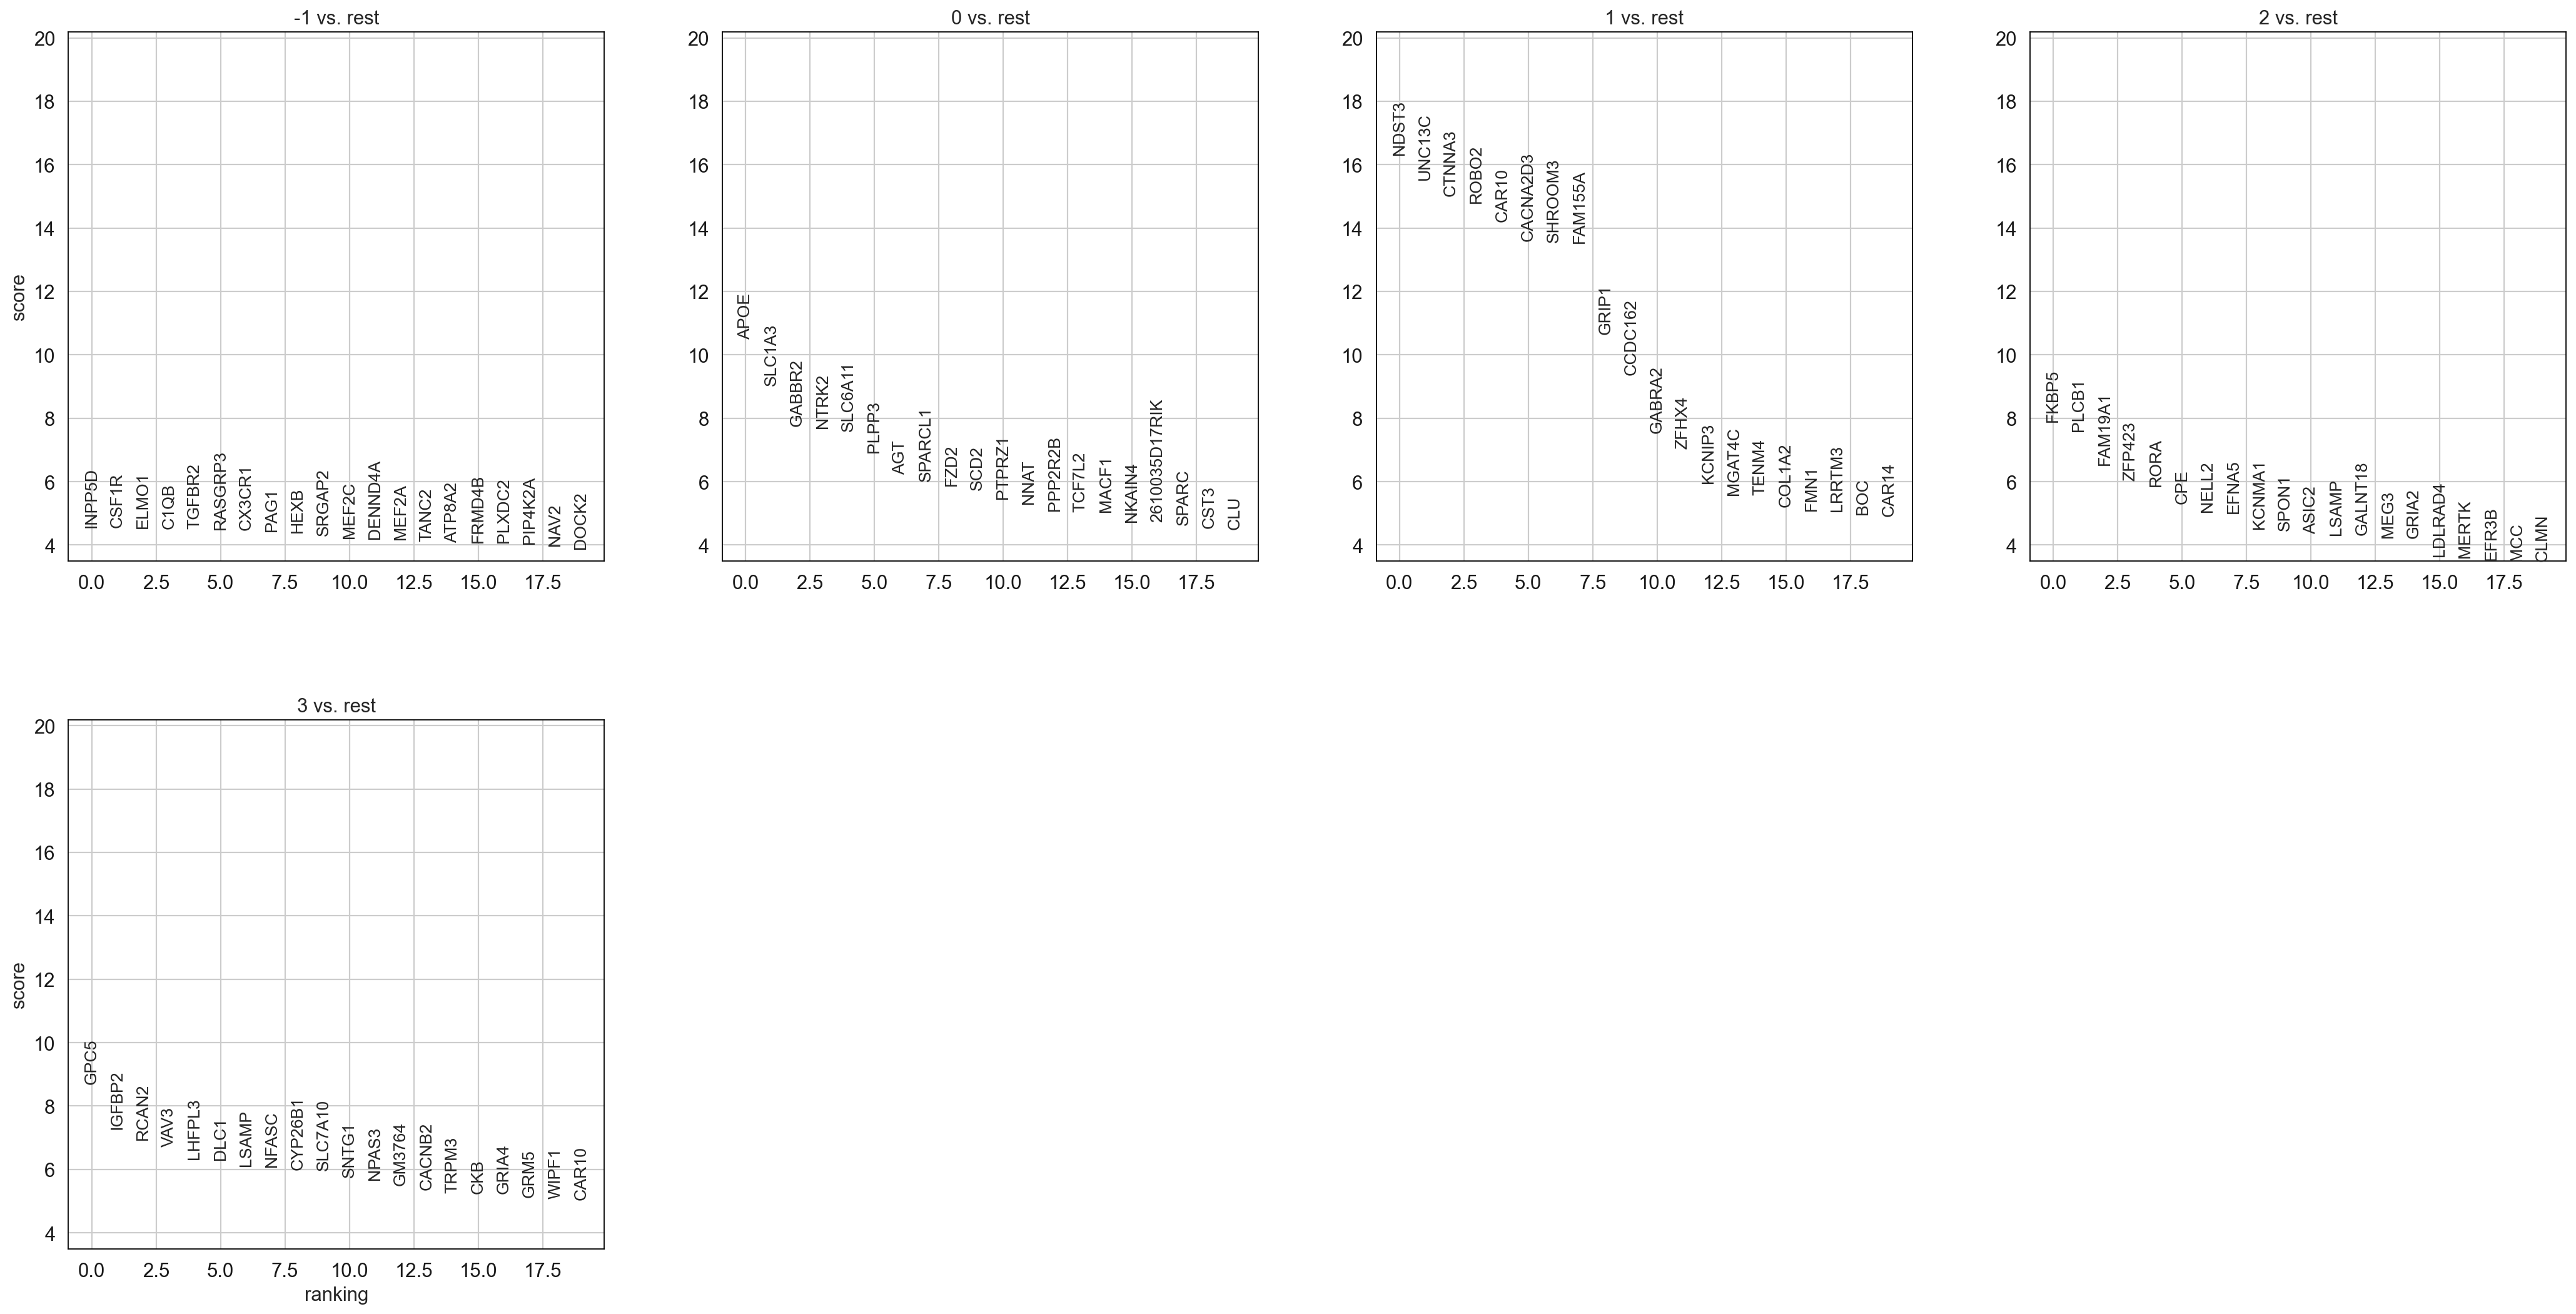

In [60]:
sc.tl.rank_genes_groups(adata_astro_BS, groupby='PhenoGraph_clusters_astro_BS', key_added="ranked_genes_pheno_astro", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro_BS, key = 'ranked_genes_pheno_astro', fontsize=12)

In [125]:
n_genes = 10000
key_ad ='ranked_genes_pheno_astro'
result = adata_astro_BS.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [126]:
pval_table

-1_n       -1_l      -1_p      0_n       0_l           0_p  \
0     INPP5D  12.709837  0.012469     APOE  1.061012  2.151480e-22   
1      CSF1R  11.704638  0.012469   SLC1A3  1.524098  2.402211e-16   
2      ELMO1   8.444152  0.012469   GABBR2  2.118260  8.789292e-12   
3       C1QB  10.253157  0.012469    NTRK2  0.908452  1.417463e-11   
4     TGFBR2   9.711541  0.012469  SLC6A11  0.801774  2.753096e-11   
...      ...        ...       ...      ...       ...           ...   
9995    ELP4  -0.322258  0.985068   ELAVL3 -0.497733  1.000000e+00   
9996  HIVEP1  -0.774825  0.985068   S100A1 -0.800914  1.000000e+00   
9997  UNC13C  -0.512434  0.985068     ACP2 -0.455149  1.000000e+00   
9998    LDLR  -0.614025  0.985068    ZFP61 -1.916404  1.000000e+00   
9999  SFSWAP  -0.548496  0.985068    ACADM -0.454251  1.000000e+00   

                1_n       1_l           1_p      2_n       2_l           2_p  \
0             NDST3  4.452377  6.970175e-56    FKBP5  2.779066  3.133780e-11   
1            UNC13C  4.370820  1.171397e-50    PLCB1  0.709048  1.819067e-10   
2            CTNNA3  3.993734  2.315607e-47  FAM19A1  1.713441  1.134734e-07   
3             ROBO2  3.806719  4.340125e-46   ZFP423  1.679940  1.934903e-06   
4             CAR10  3.053478  2.055707e-42     RORA  0.472839  4.513672e-06   
...             ...       ...           ...      ...       ...           ...   
9995            OS9 -0.303121  1.000000e+00   LPCAT1 -1.062235  9.998233e-01   
9996         YTHDC2 -0.265679  1.000000e+00    EXOC5 -0.575667  9.998233e-01   
9997         LRRC49 -0.164661  1.000000e+00    APAF1 -0.870085  9.998233e-01   
9998  4930523C07RIK -0.936603  1.000000e+00  ZFYVE27 -0.787209  9.998233e-01   
9999           CBR3 -1.310014  1.000000e+00   SPATS2 -0.776955  9.998233e-01   

           3_n       3_l           3_p  
0         GPC5  0.982068  3.808823e-14  
1       IGFBP2  2.654064  1.374447e-09  
2        RCAN2  2.137442  1.129391e-08  
3         VAV3  2.027736  4.275040e-08  
4       LHFPL3  2.009422  4.488376e-07  
...        ...       ...           ...  
9995      AIG1 -0.160796  9.999727e-01  
9996    ZSWIM7 -0.685342  9.999727e-01  
9997  RAB3GAP2 -0.249654  9.999727e-01  
9998     UCHL3 -0.702878  9.999727e-01  
9999     KHNYN -1.257572  9.999727e-01  

[10000 rows x 15 columns]

In [ ]:
pval_table = pval_table.sort_values(by= 'group_0_1_3_4_6VE_l', ascending=False)
pval_table[(pval_table.group_0_1_3_4_6VE_p < 0.05) & (pval_table.group_0_1_3_4_6VE_l > 0.5)].head(10)

In [61]:
adata_astro_BS.obs.PhenoGraph_clusters_astro_BS.value_counts()

0     346
1     344
2     180
3     162
-1      7
Name: PhenoGraph_clusters_astro_BS, dtype: int64

## Visualize marker genes using heatmap

In [189]:
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_astro_BS_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

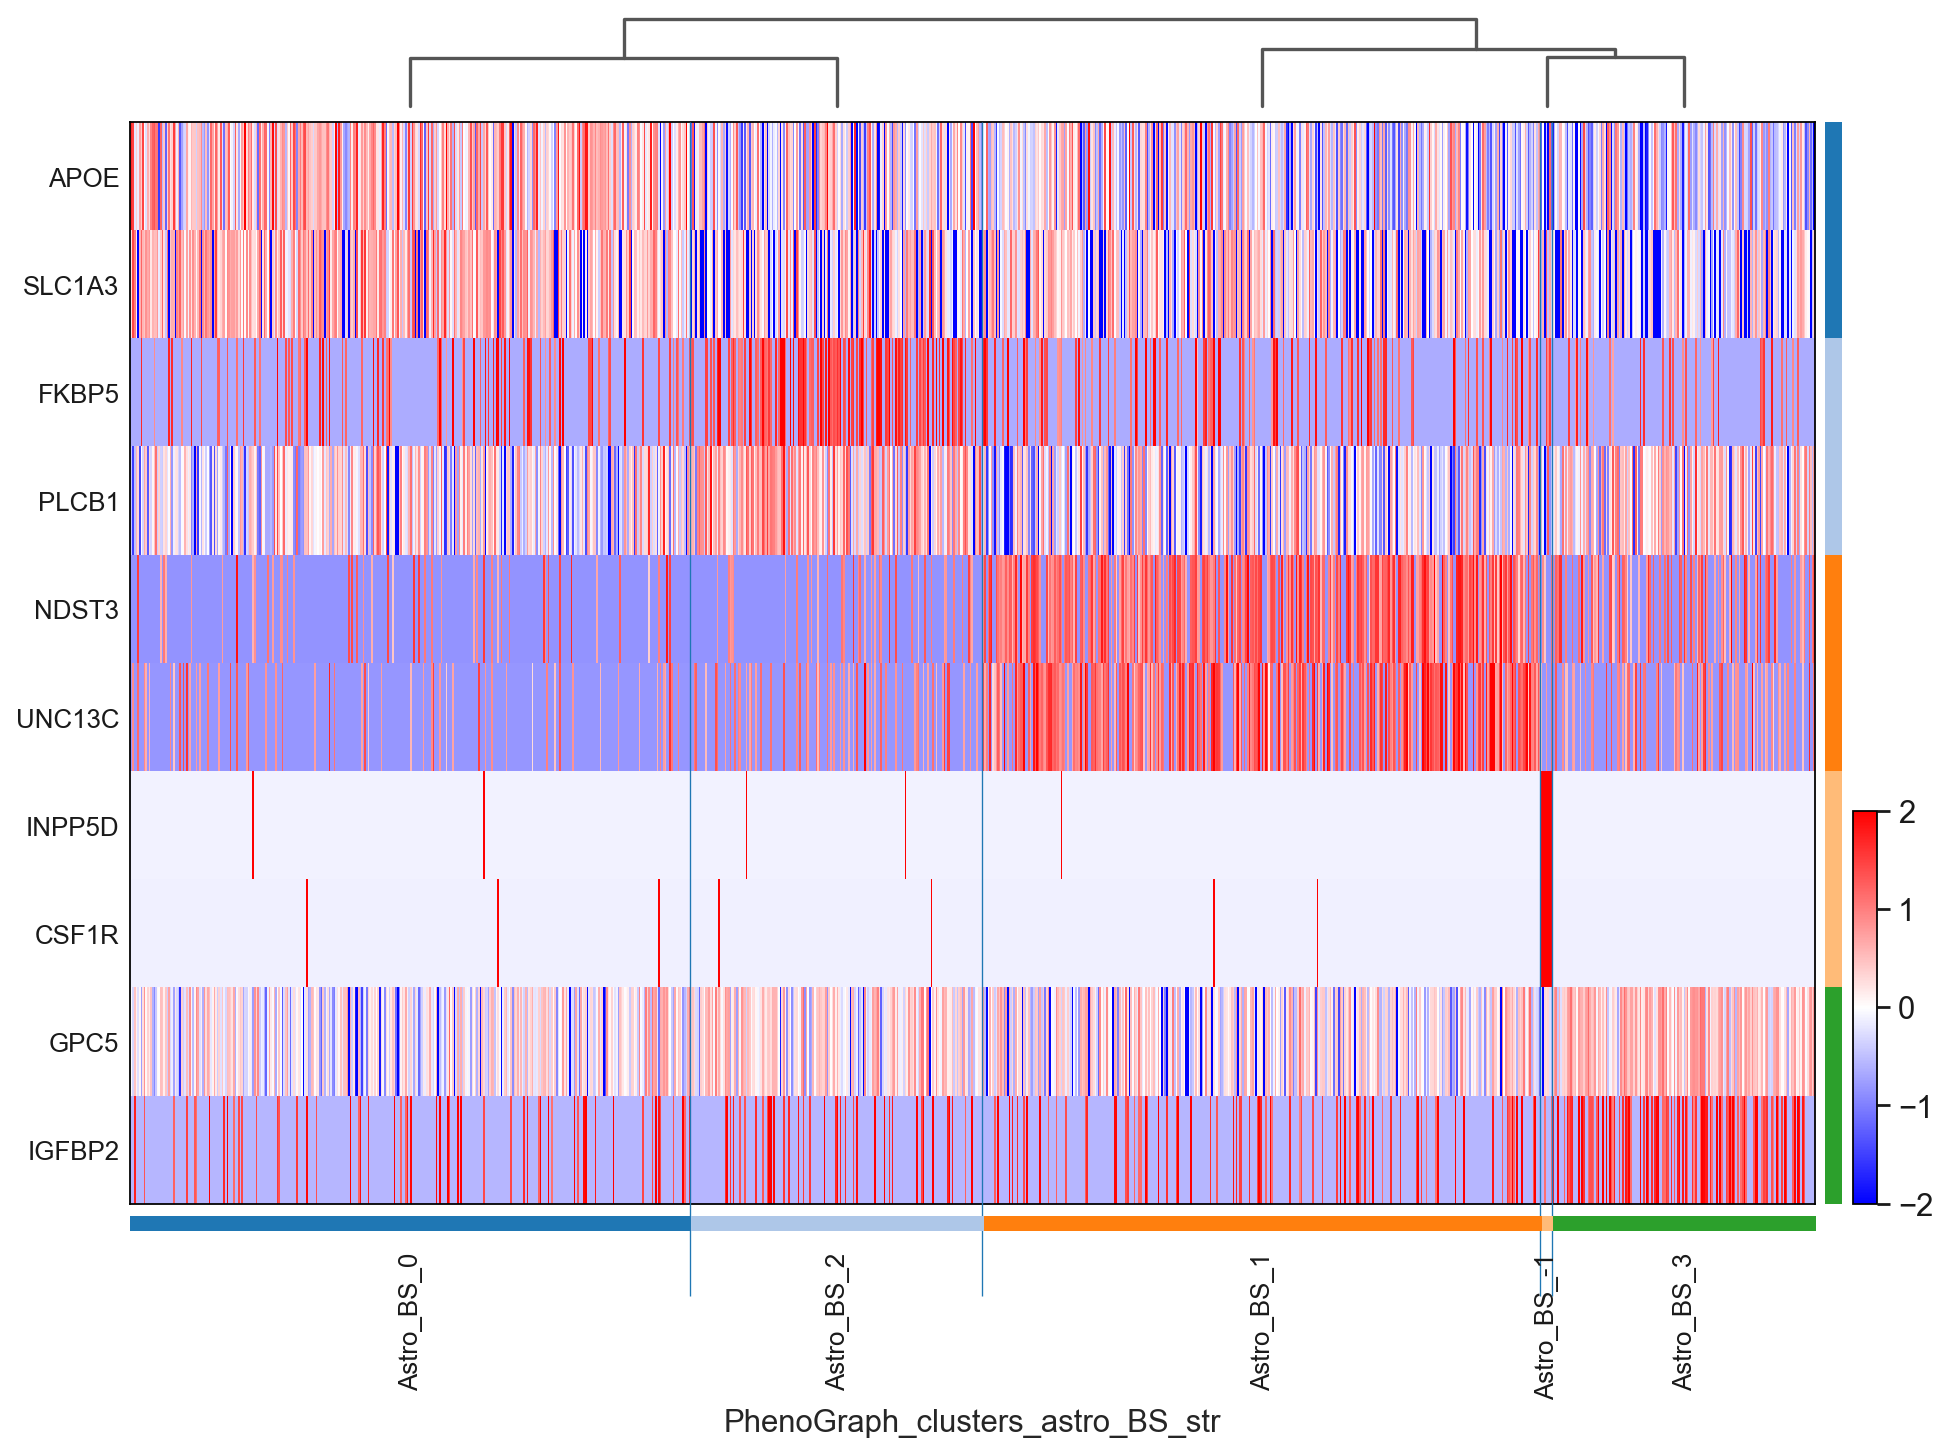

In [190]:
sc.tl.rank_genes_groups(adata_astro_BS, groupby='PhenoGraph_clusters_astro_BS_str', n_genes=adata_astro_BS.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_astro_BS, n_genes=2, use_raw=False, swap_axes=True, vmin=-2, vmax=2, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

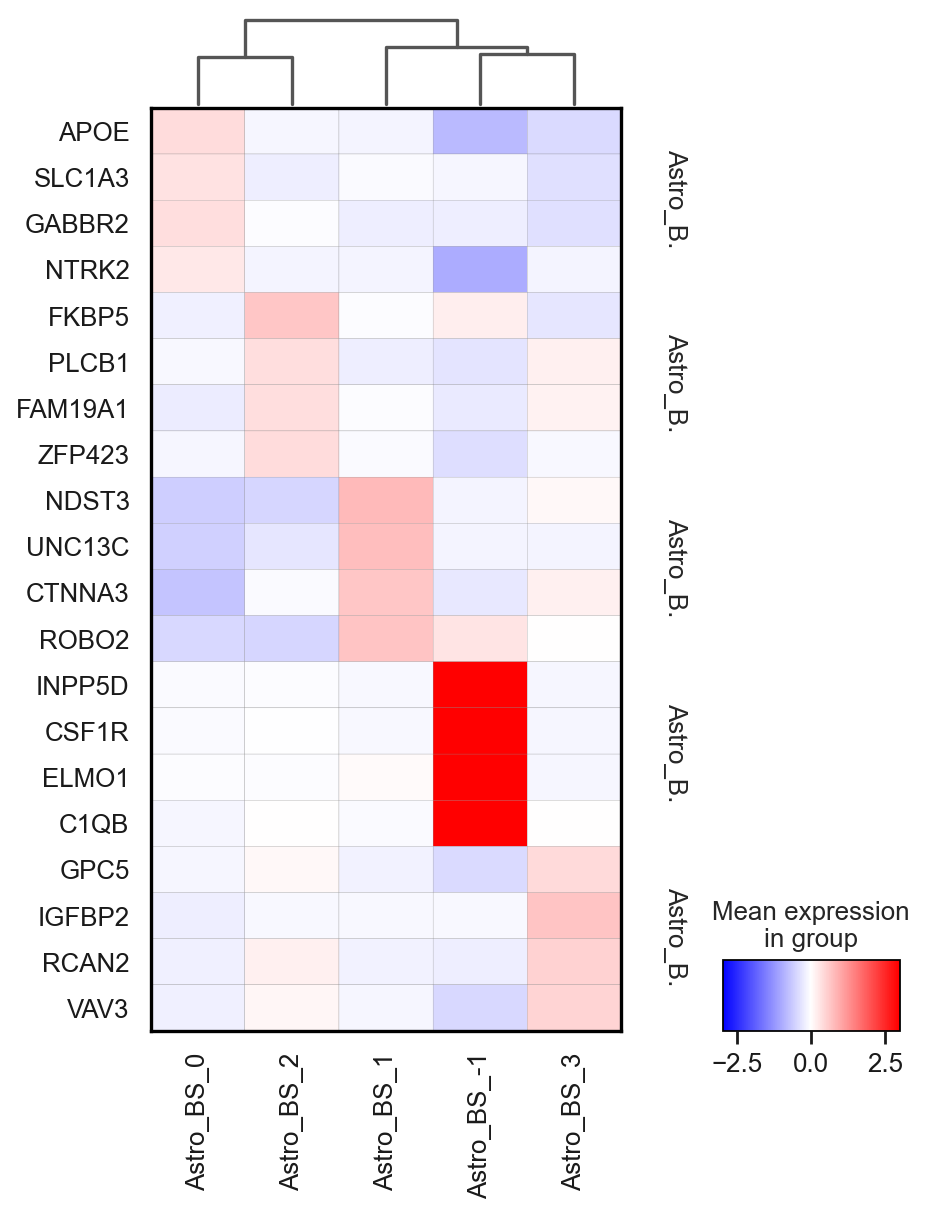

In [129]:
sc.pl.rank_genes_groups_matrixplot(adata_astro_BS, n_genes=4, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(6,8), show=False)

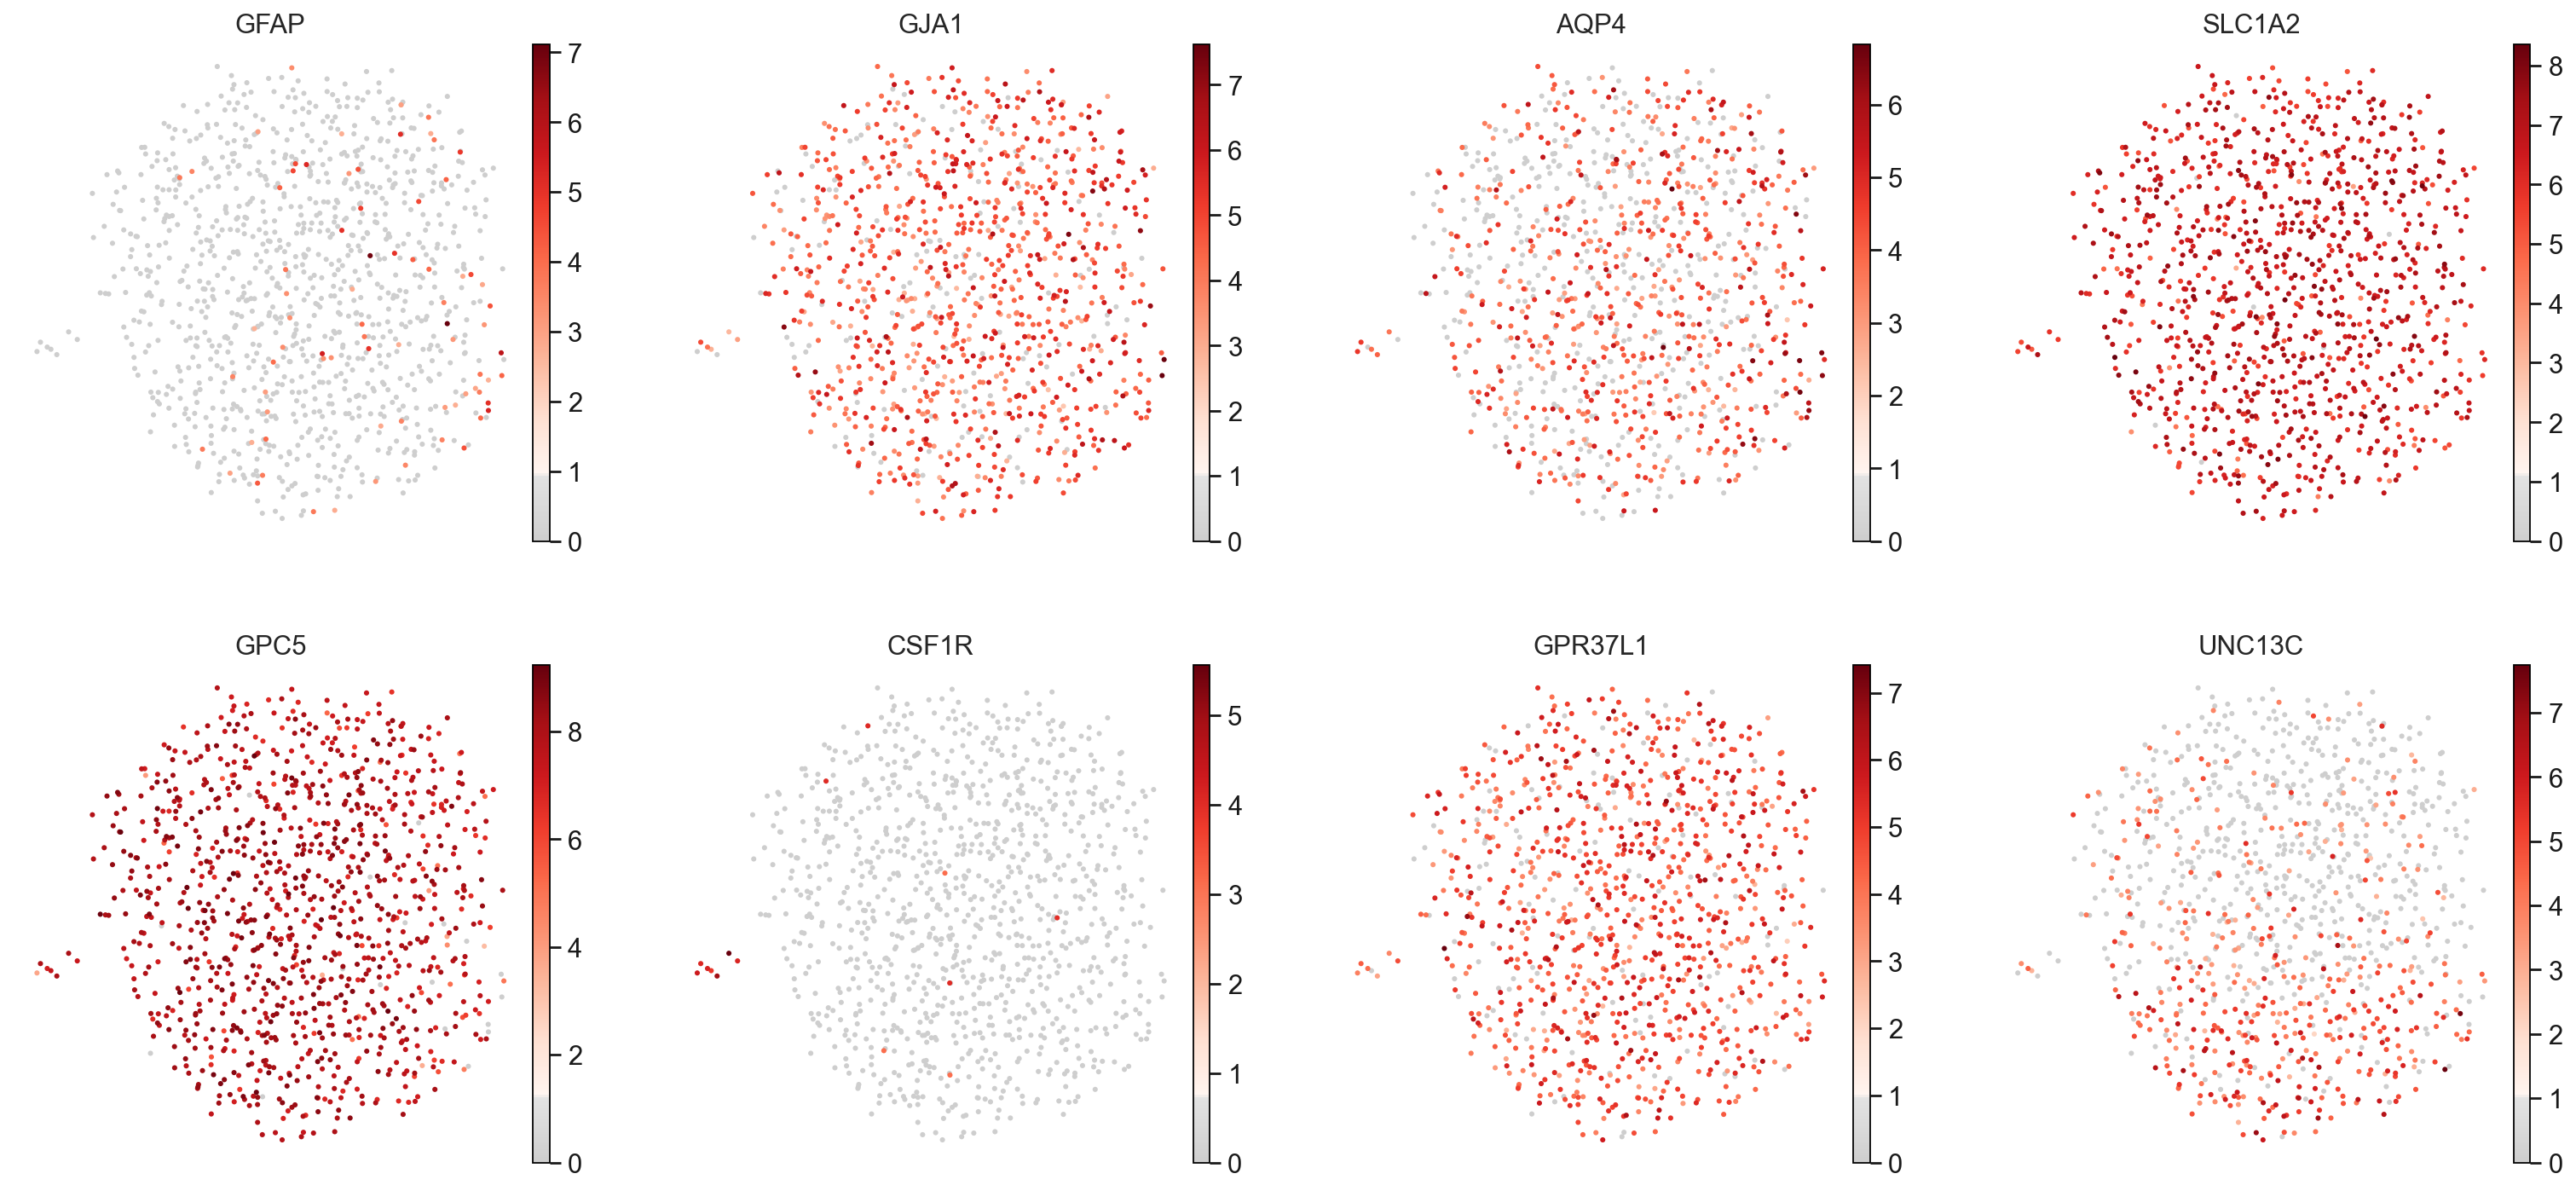

In [191]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_astro_BS,
           size = 30,
           color=['GFAP', 'GJA1','AQP4','SLC1A2','GPC5','CSF1R','GPR37L1','UNC13C'],
           color_map=mymap,
          frameon=False, )

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

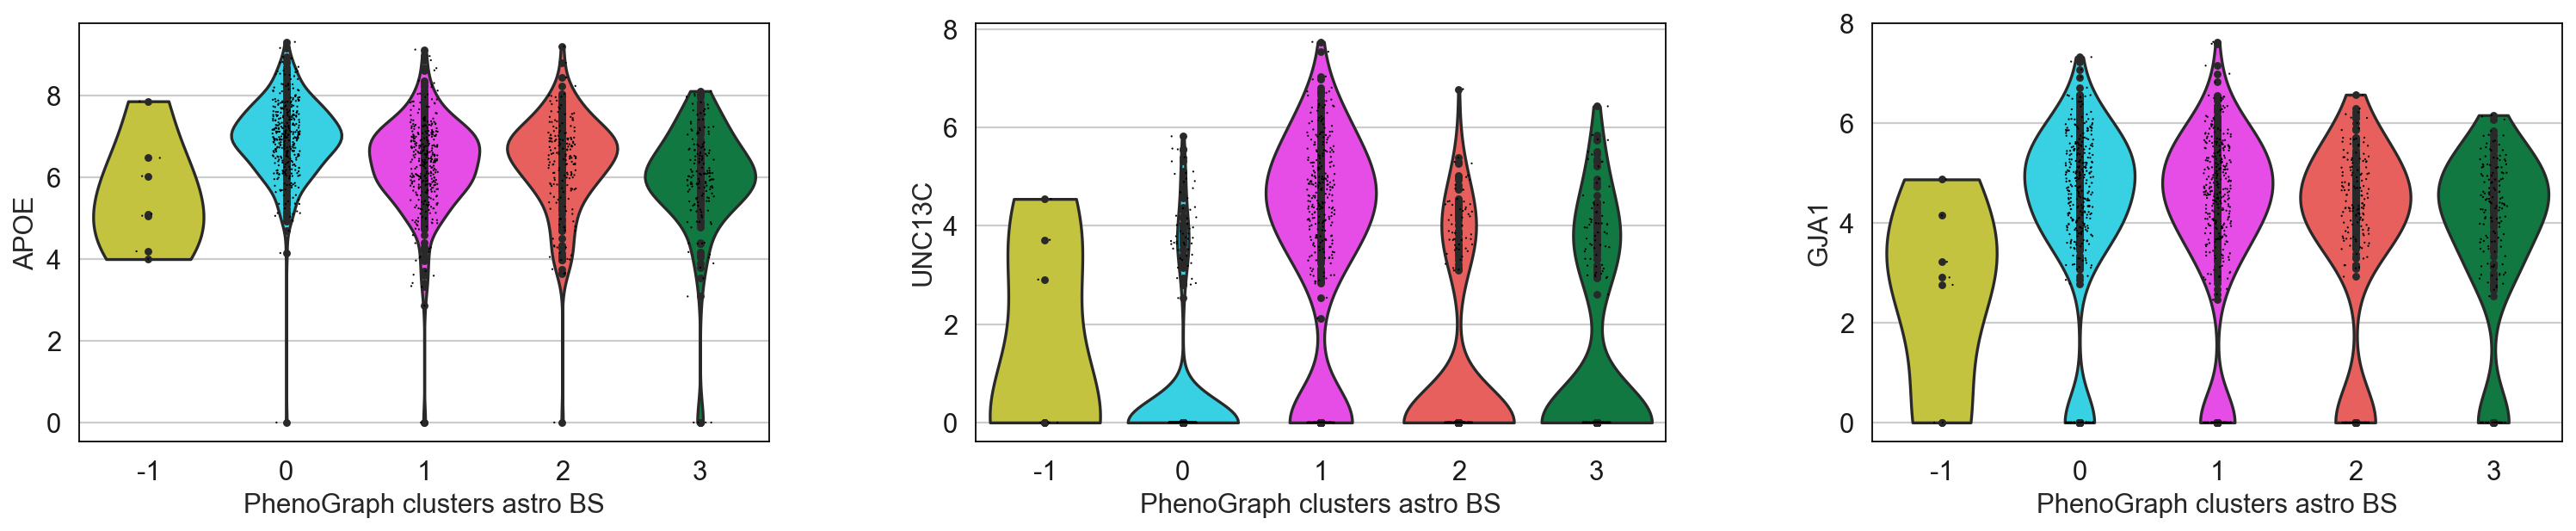

In [163]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.violin(adata_astro_BS, ['APOE','UNC13C','GJA1'], groupby='PhenoGraph_clusters_astro_BS', inner='point', palette = godsnot_64)

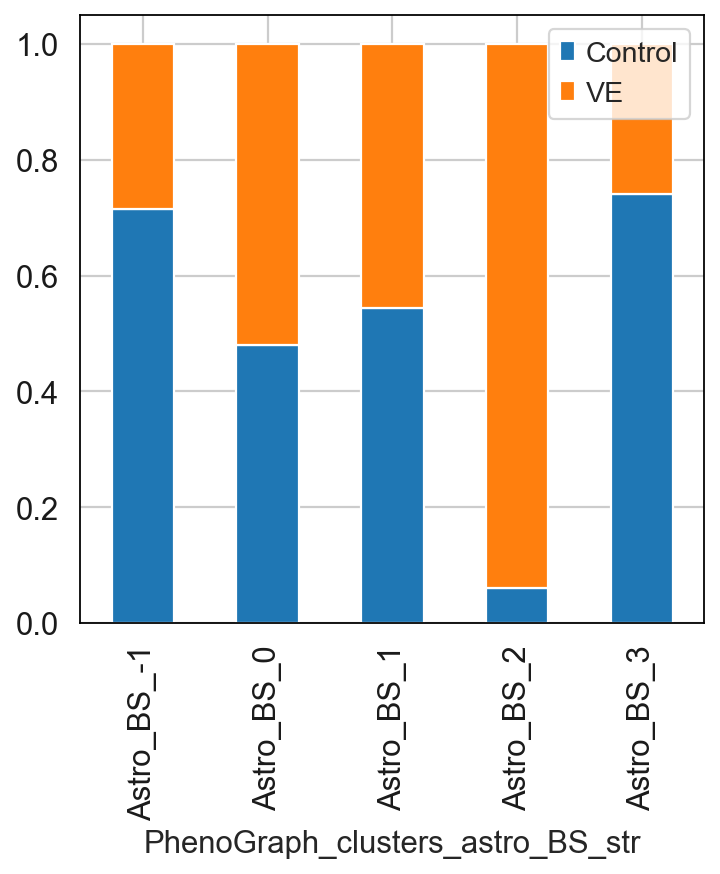

In [182]:
sc.set_figure_params(figsize=(5, 5))
tmp = pd.crosstab(adata_astro_BS.obs['PhenoGraph_clusters_astro_BS_str'],adata_astro_BS.obs['Condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

# Save result Adata Oligodendrocytes

In [66]:
#adata_astro_BS.write_h5ad(outdir+'adata_high_var_Astrocytes_Brainstem_clusters.h5ad')

Load the adata object that holds the latest cell type annotations..

In [11]:
adata_astro_BS = sc.read_h5ad(outdir+'adata_high_var_Astrocytes_Brainstem_clusters.h5ad')

## Remove the cluster with 7 cells. 

In [12]:
adata_astro_BS.obs.loc[adata_astro_BS.obs['PhenoGraph_clusters_astro_BS_str'] == 'Astro_BS_-1', 'Astro_BS_subclusters'] = 'mix'
adata_astro_BS.obs.loc[adata_astro_BS.obs['PhenoGraph_clusters_astro_BS_str'] != 'Astro_BS_-1', 'Astro_BS_subclusters'] = 'Astrocytes'

In [13]:
adata_astro_BS_only = deepcopy(adata_astro_BS)
adata_astro_BS_only = adata_astro_BS[adata_astro_BS.obs['Astro_BS_subclusters'].isin(['Astrocytes']),:]
adata_astro_BS_only.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1032, 11569)

# Differential expression with MAST (BS ALL samples)

Astrocytes Brainstem clusters only

In [ ]:
run_MAST_for_celltype_condition(adata_astro_BS_only, "Astrocytes")

In [14]:
# import the MAST results
mast_astro_BS = pd.read_csv (filepath_or_buffer= '../DEA/Astrocytes_Brainstem/MAST_DEA_Astrocytes_RESULTS.csv')
print(mast_astro_BS)

          gene             p     p.fdr.adj     logFC
0        FKBP5  2.253986e-52  2.607637e-48  1.921319
1        NPAS3  8.194024e-30  4.739833e-26 -0.554146
2          SON  1.784910e-29  6.883207e-26 -0.879372
3          NTM  5.221607e-27  1.510219e-23 -0.503744
4       MGAT4C  4.579159e-20  1.059526e-16 -0.953608
...        ...           ...           ...       ...
11564     IAH1  9.996181e-01  9.999639e-01 -0.001062
11565    EIF5B  9.997989e-01  9.999718e-01  0.001138
11566  PLA2G4A  9.997635e-01  9.999718e-01  0.000163
11567     CAST  1.000000e+00  1.000000e+00 -0.000250
11568  EIF2AK2  1.000000e+00  1.000000e+00 -0.001404

[11569 rows x 4 columns]


In [55]:
 mast_astro_BS[mast_astro_BS['p.fdr.adj'] <= 0.05]

gene             p     p.fdr.adj     logFC
0     FKBP5  2.253986e-52  2.607637e-48  1.921319
1     NPAS3  8.194024e-30  4.739833e-26 -0.554146
2       SON  1.784910e-29  6.883207e-26 -0.879372
3       NTM  5.221607e-27  1.510219e-23 -0.503744
4    MGAT4C  4.579159e-20  1.059526e-16 -0.953608
..      ...           ...           ...       ...
395    SDK1  1.646622e-03  4.810549e-02  0.205245
396     B2M  1.696053e-03  4.917705e-02  0.215381
397  ELOVL5  1.692752e-03  4.917705e-02 -0.443511
398  SEL1L3  1.692599e-03  4.917705e-02  0.250286
399    PPIB  1.724149e-03  4.986669e-02 -0.019504

[400 rows x 4 columns]

In [57]:
#filter DE results
mast_astro_BS = mast_astro_BS.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_astro_BS_UP = mast_astro_BS[(mast_astro_BS['logFC'] >=0.5) & (mast_astro_BS['p.fdr.adj'] <= 0.05)]
mast_astro_BS_DOWN = mast_astro_BS[(mast_astro_BS['logFC'] <=-0.5) & (mast_astro_BS['p.fdr.adj'] <= 0.05)]
#mast_C0_res_UP['gene'].head(20)
mast_astro_BS_UP.shape

(74, 4)

In [ ]:
mast_astro_BS_DOWN.sort_values(by='p.fdr.adj', ascending=True).head(10)

**FOR GO**

In [134]:
mast_astro_BS_UP_for_GO = mast_astro_BS[(mast_astro_BS['p.fdr.adj'] <= 0.05) & (mast_astro_BS['logFC'] >=0.05)]
mast_astro_BS_DOWN_for_GO = mast_astro_BS[(mast_astro_BS['p.fdr.adj'] <= 0.05) & (mast_astro_BS['logFC'] <=-0.05)]

## Volcano plot

In [58]:
mast_astro_BS = mast_astro_BS.dropna()
sc.set_figure_params(figsize=(6, 4))

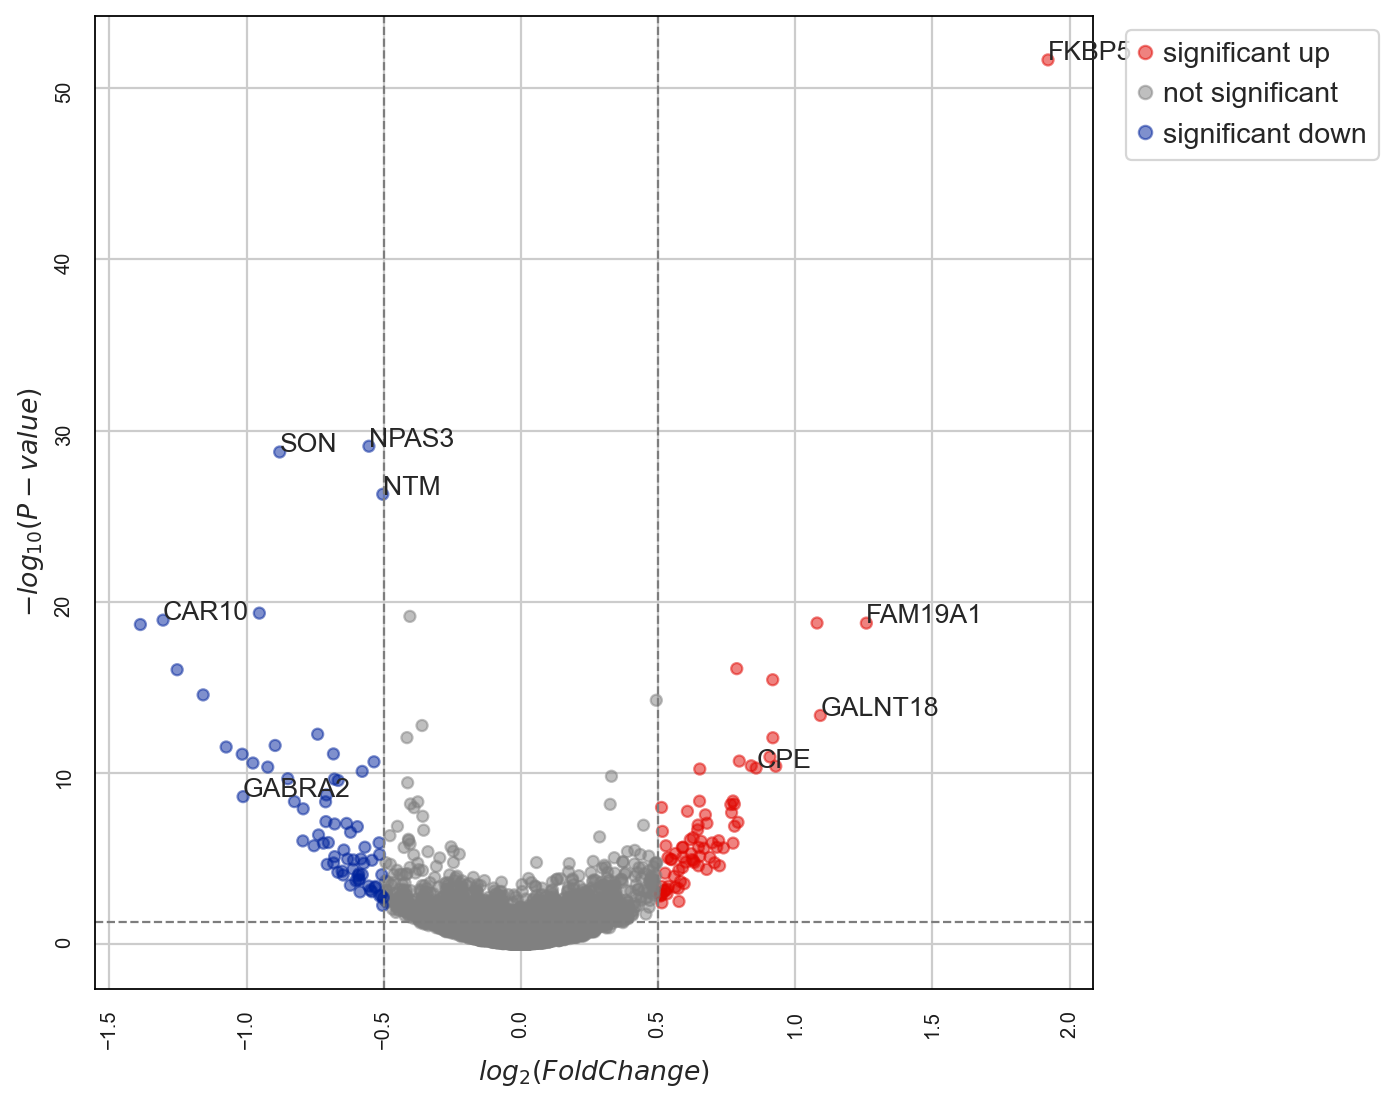

In [61]:
from bioinfokit import analys, visuz
visuz.gene_exp.volcano(df=mast_astro_BS, lfc='logFC', pv='p',show=True, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.3,1),color=("#E10600FF", "grey", "#00239CFF"), valpha=0.5, dotsize=25, geneid="gene", 
                       genenames=('FKBP5', 'FAM19A1', 'GALNT18','CPE', 'CAR10','GABRA2','NPAS3','SON','NTM'),  sign_line=True, gfont = 12, dim=(8,8), axlabelfontsize = 12,lfc_thr=(0.5, 0.5))

## Heatmaps of gene expression of top DEA genes

### All Brainstem samples

In [65]:
top2_per_cluster= np.array([
'APOE',
"SLC1A3",
'NDST3',
'UNC13C',
"FKBP5",
'PLCB1',
'GPC5',
'IGFBP2'])
top2_per_cluster = pd.Series(data=top2_per_cluster)


to_plot = pd.concat([top2_per_cluster, mast_astro_BS_UP['gene'].head(20)])

In [ ]:
marker_genes_dict = dict()

marker_genes_dict = {'Astro-BS': to_plot}

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'Astro_BS_subclusters' as categorical


categories: Astro_BS_0_Control, Astro_BS_0_VE, Astro_BS_1_Control, etc.
var_group_labels: Astro-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


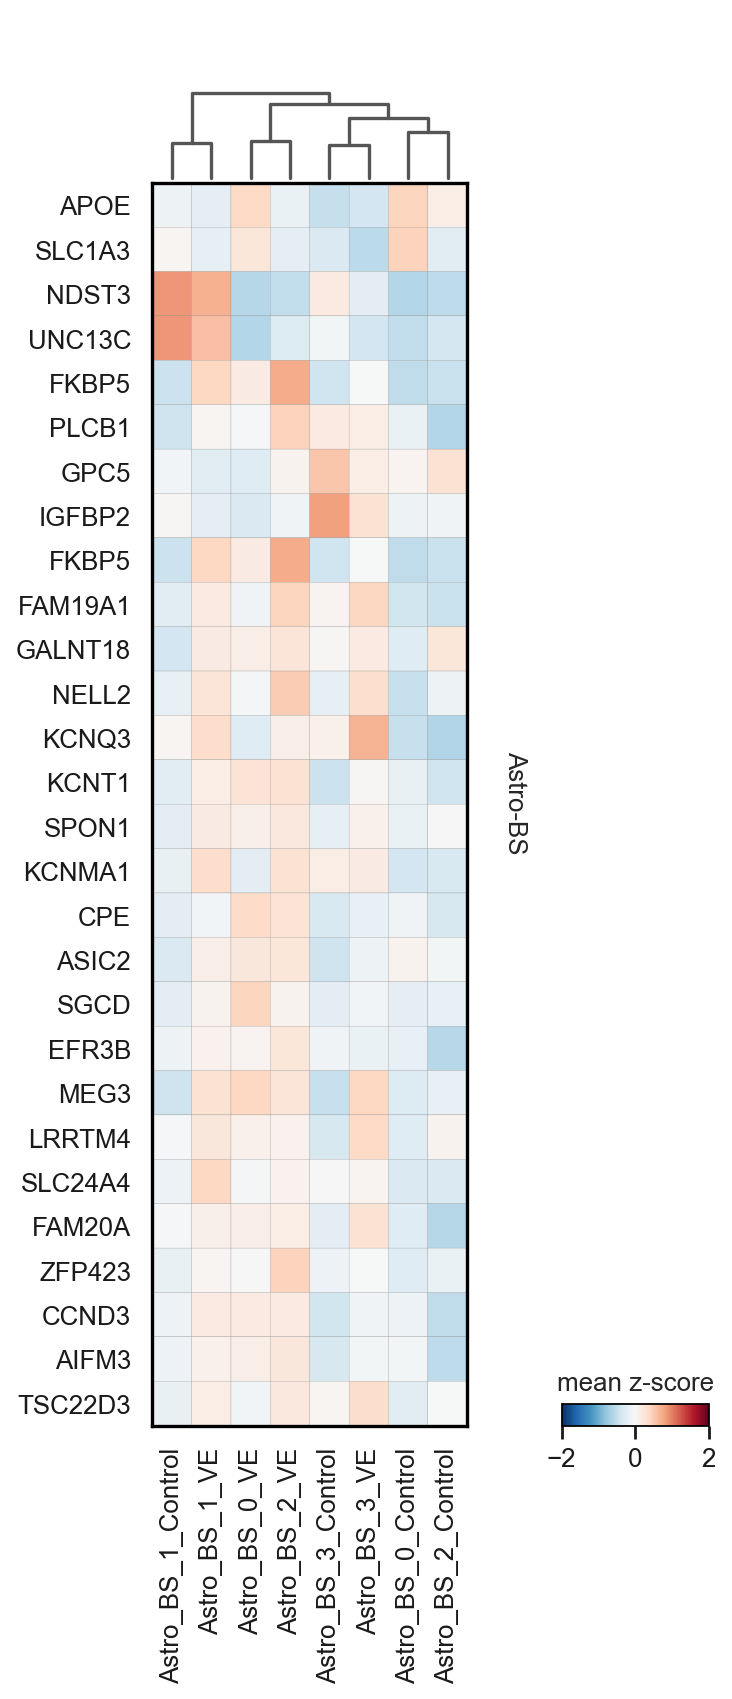

categories: Astro_BS_0_Control, Astro_BS_0_VE, Astro_BS_1_Control, etc.
var_group_labels: Astro-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


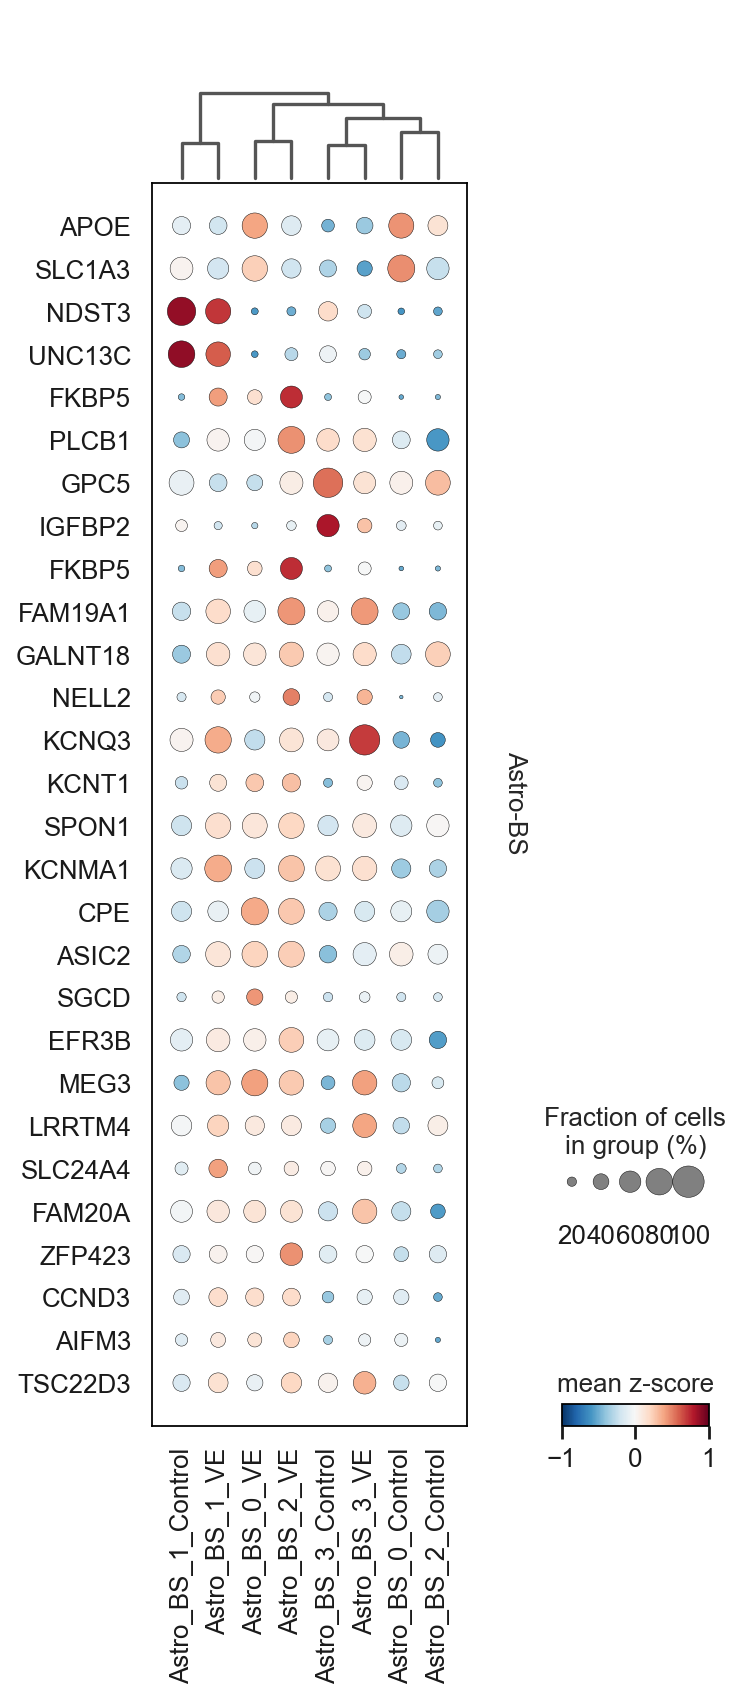

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


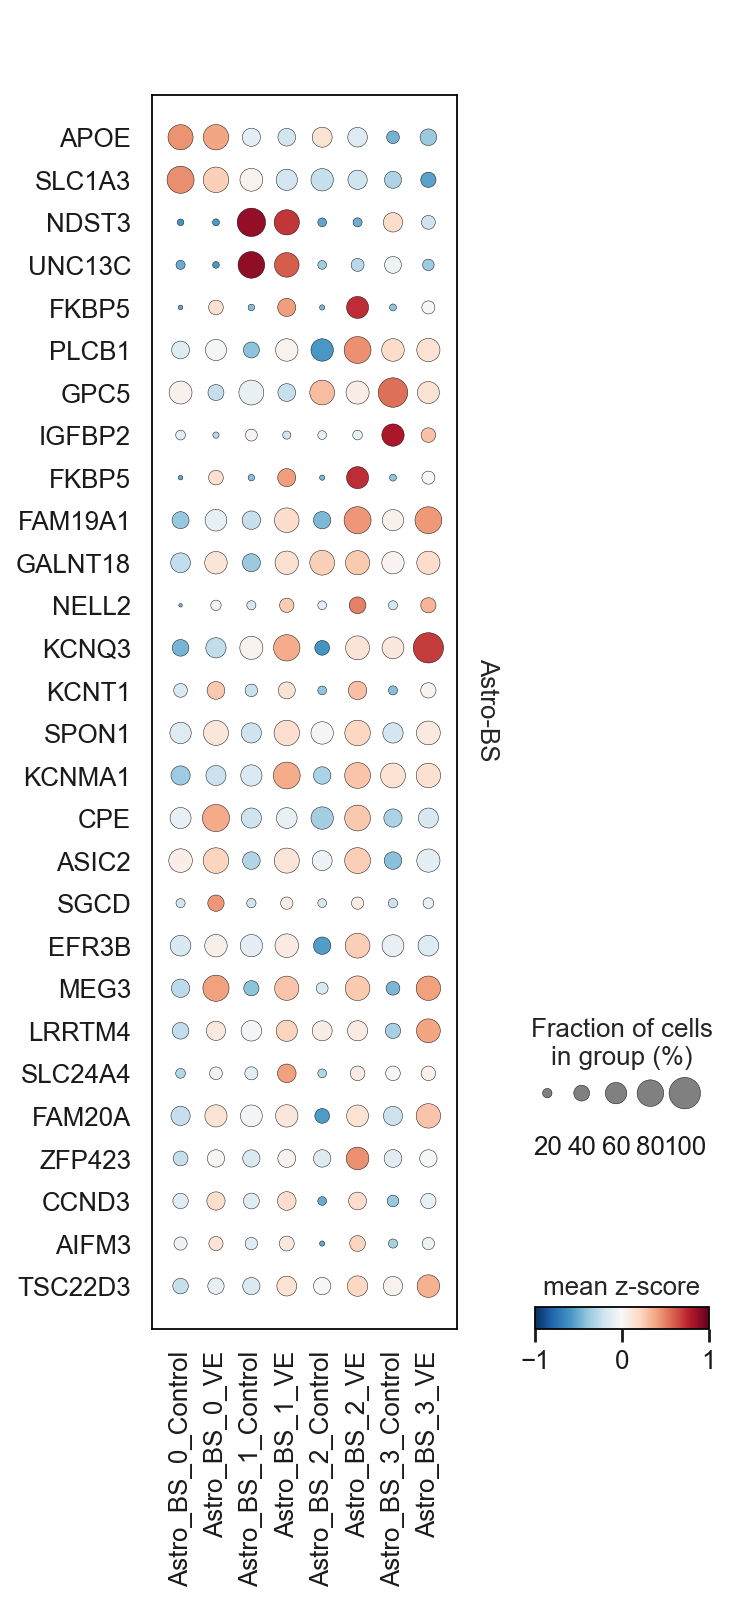

In [73]:
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X
sc.pl.matrixplot(adata_astro_BS_only, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS_only, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS_only, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

## ALL clusters Enrichr 

In [143]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_astro_BS_UP_n_list = mast_astro_BS_DOWN_for_GO.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_astro_BS_UP_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [144]:
enr_res.results.head(15)

Gene_set                                               Term  \
0   KEGG_2019_Mouse            Proximal tubule bicarbonate reclamation   
1   KEGG_2019_Mouse                                     Bile secretion   
2   KEGG_2019_Mouse                             Gastric acid secretion   
3   KEGG_2019_Mouse                                 Nicotine addiction   
4   KEGG_2019_Mouse                               Steroid biosynthesis   
5   KEGG_2019_Mouse                             cAMP signaling pathway   
6   KEGG_2019_Mouse                                  GABAergic synapse   
7   KEGG_2019_Mouse                                 Morphine addiction   
8   KEGG_2019_Mouse                               Pancreatic secretion   
9   KEGG_2019_Mouse  Arrhythmogenic right ventricular cardiomyopath...   
10  KEGG_2019_Mouse                          Thyroid hormone synthesis   
11  KEGG_2019_Mouse          Aldosterone-regulated sodium reabsorption   
12  KEGG_2019_Mouse                                  Insulin secretion   
13  KEGG_2019_Mouse                          Calcium signaling pathway   
14  KEGG_2019_Mouse                            Notch signaling pathway   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     5/22  0.000002          0.000249            0                     0   
1     6/72  0.000058          0.003572            0                     0   
2     6/74  0.000067          0.003572            0                     0   
3     4/40  0.000520          0.020665            0                     0   
4     3/19  0.000698          0.022196            0                     0   
5    8/211  0.000855          0.022651            0                     0   
6     5/90  0.001567          0.034320            0                     0   
7     5/92  0.001727          0.034320            0                     0   
8    5/105  0.003077          0.054353            0                     0   
9     4/72  0.004642          0.070475            0                     0   
10    4/73  0.004876          0.070475            0                     0   
11    3/38  0.005335          0.070691            0                     0   
12    4/86  0.008664          0.100125            0                     0   
13   6/189  0.008816          0.100125            0                     0   
14    3/49  0.010812          0.114604            0                     0   

    Odds Ratio  Combined Score  \
0    31.990950      427.592046   
1     9.918132       96.798098   
2     9.625447       92.450794   
3    12.007893       90.802727   
4    20.173573      146.607543   
5     4.317362       30.500811   
6     6.376212       41.183304   
7     6.229001       39.625676   
8     5.415659       31.323789   
9     6.346834       34.099296   
10    6.254534       33.296007   
11    9.213354       48.217530   
12    5.259496       24.975296   
13    3.555837       16.823319   
14    7.006262       31.718204   

                                                Genes  
0                   CAR2;ATP1A2;ATP1B2;SLC38A3;SLC4A4  
1               CAR2;ATP1A2;ADCY2;ATP1B2;HMGCR;SLC4A4  
2              CAR2;KCNJ10;ATP1A2;ADCY2;ATP1B2;CAMK2G  
3                           GRIA1;GABRA2;GABRB1;GRIA4  
4                                    SQLE;MSMO1;DHCR7  
5   GRIA1;PDE4D;PDE4B;ATP1A2;ADCY2;ATP1B2;CAMK2G;G...  
6                 GABRA2;GABRB1;SLC6A11;ADCY2;SLC38A3  
7                     GABRA2;GABRB1;PDE4D;PDE4B;ADCY2  
8                     CAR2;ATP1A2;ADCY2;ATP1B2;SLC4A4  
9                                GJA1;DAG1;DMD;CTNNA2  
10                            TTR;ATP1A2;ADCY2;ATP1B2  
11                                ATP1A2;ATP1B2;NR3C2  
12                         ATP1A2;ADCY2;ATP1B2;CAMK2G  
13               ITPKB;EDNRB;ERBB4;ADCY2;CAMK2G;TPCN1  
14                                  LFNG;NOTCH1;PSEN2

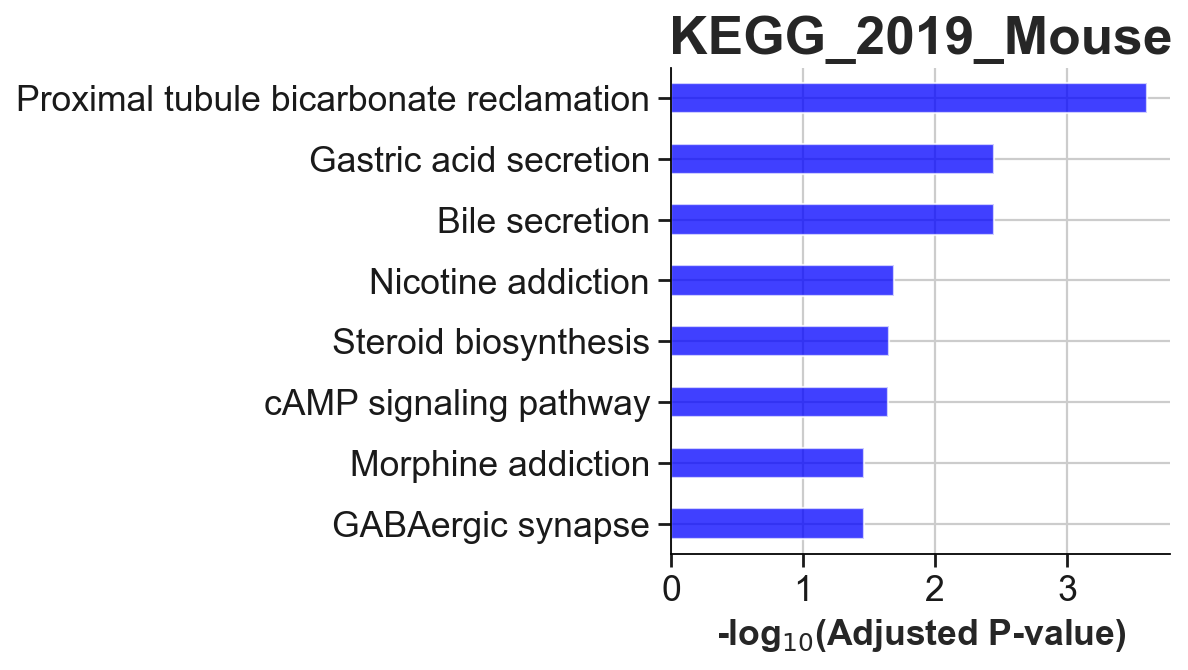

In [148]:
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse',top_term=10,color='BLUE',figsize=(4,4))

# Astrocytes BS control 

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


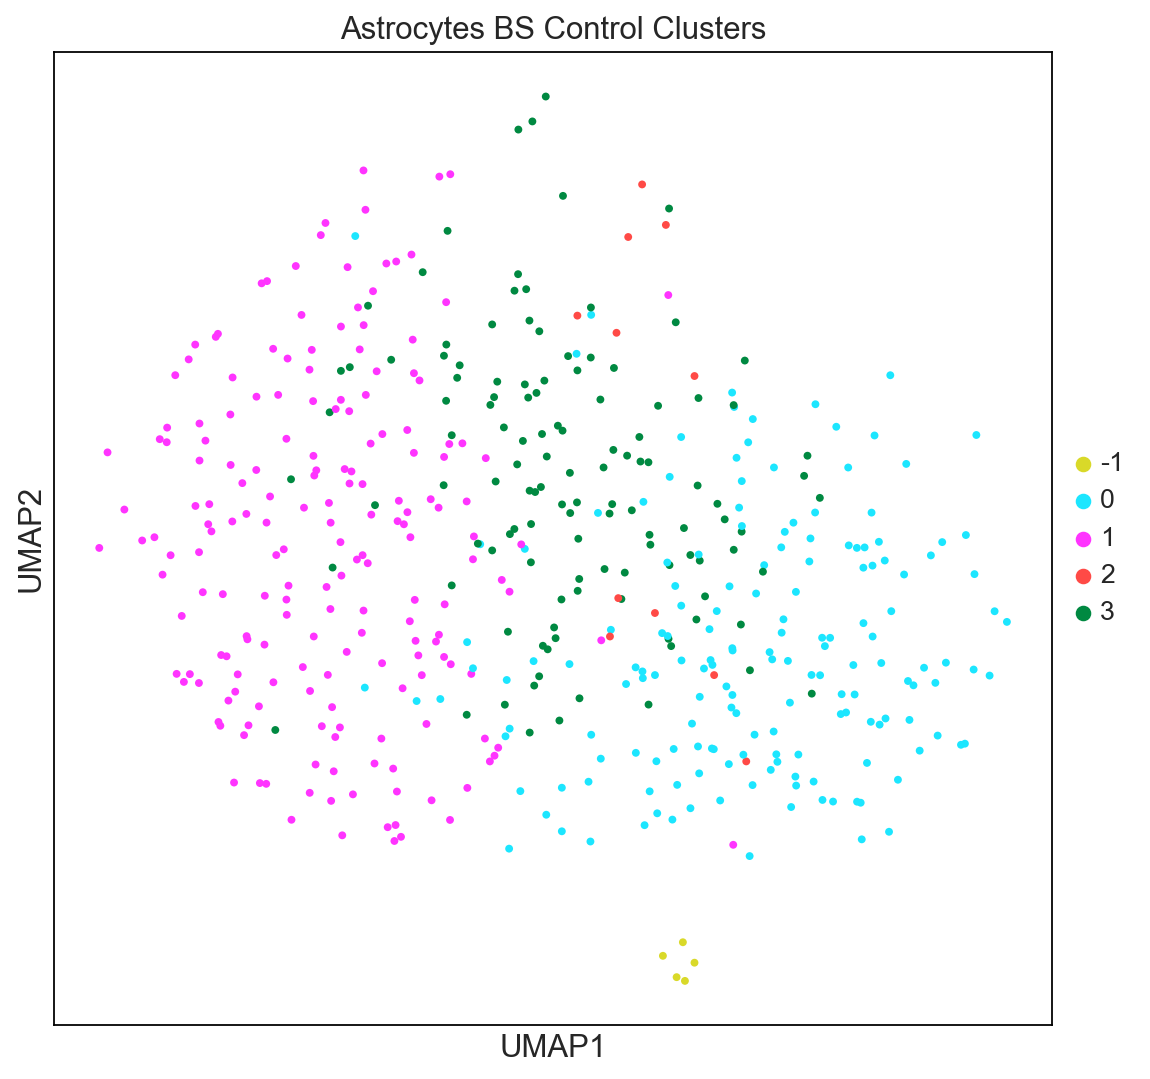

In [133]:
adata_astro_BS_control = adata_astro_BS[adata_astro_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_BS_control, 
           color= ['PhenoGraph_clusters_astro_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes BS Control Clusters"])

In [136]:
cell_counts_per_cluster_BS_ctrl = adata_astro_BS_control.obs.PhenoGraph_clusters_astro_BS.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_astro_BS
1                            187
0                            166
3                            120
2                             11
-1                             5

# Oligodendrocytes BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


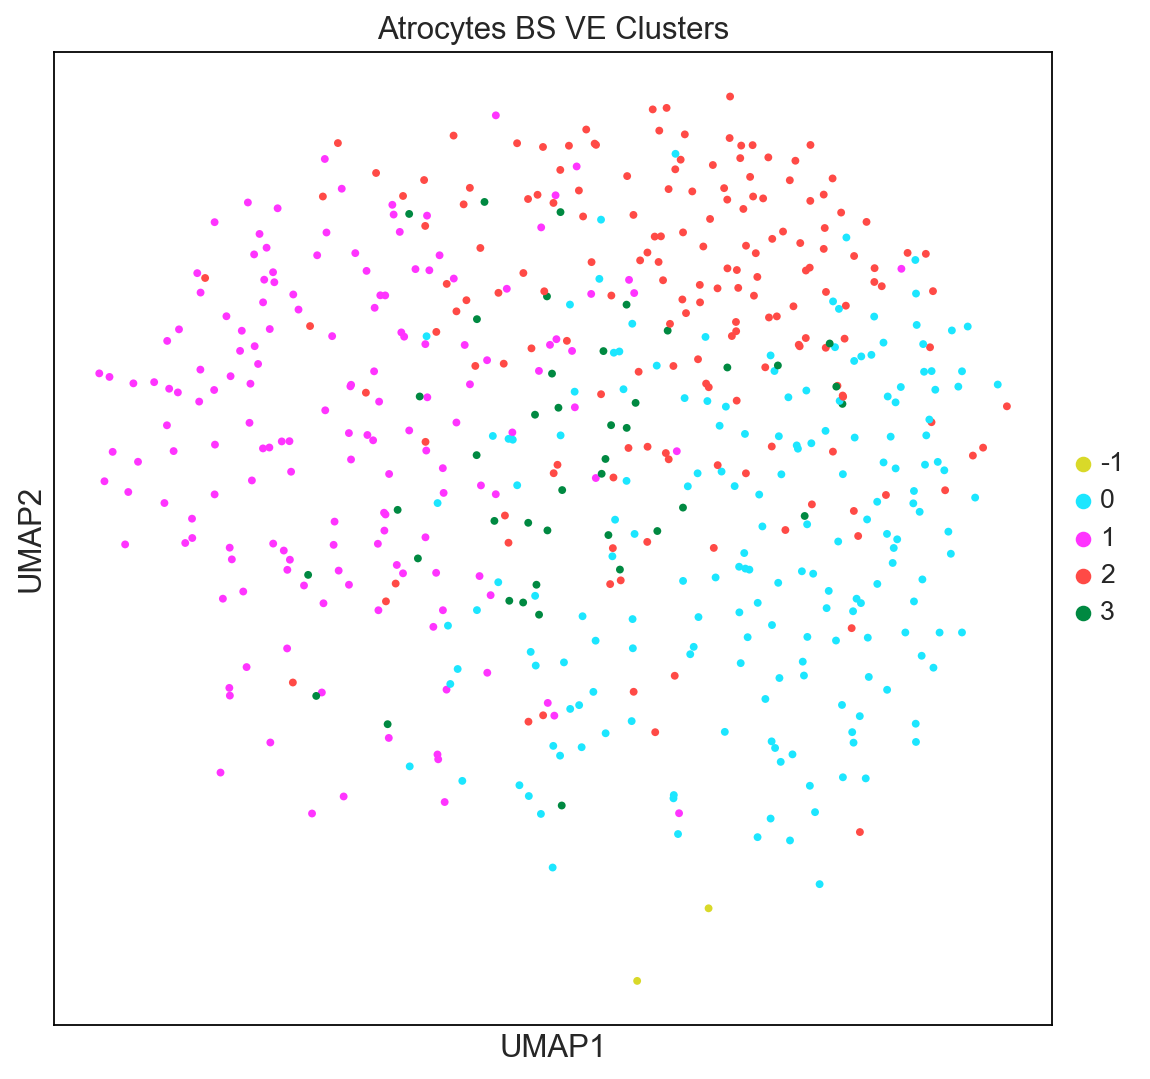

In [137]:
adata_astro_BS_VE = adata_astro_BS[adata_astro_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_BS_VE, 
           color= ['PhenoGraph_clusters_astro_BS'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Atrocytes BS VE Clusters"])

In [138]:
cell_counts_per_cluster_BS_VE = adata_astro_BS_VE.obs.PhenoGraph_clusters_astro_BS.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_astro_BS
0                            180
2                            169
1                            157
3                             42
-1                             2

# Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [139]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_astro_BS_Control' : 'Control', 'PhenoGraph_clusters_astro_BS_VE' : 'VE'}, inplace = True)
mergedDF

Control   VE
-1        5    2
0       166  180
1       187  157
2        11  169
3       120   42

In [140]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0        -1   Control        5
1         0   Control      166
2         1   Control      187
3         2   Control       11
4         3   Control      120
5        -1        VE        2
6         0        VE      180
7         1        VE      157
8         2        VE      169
9         3        VE       42

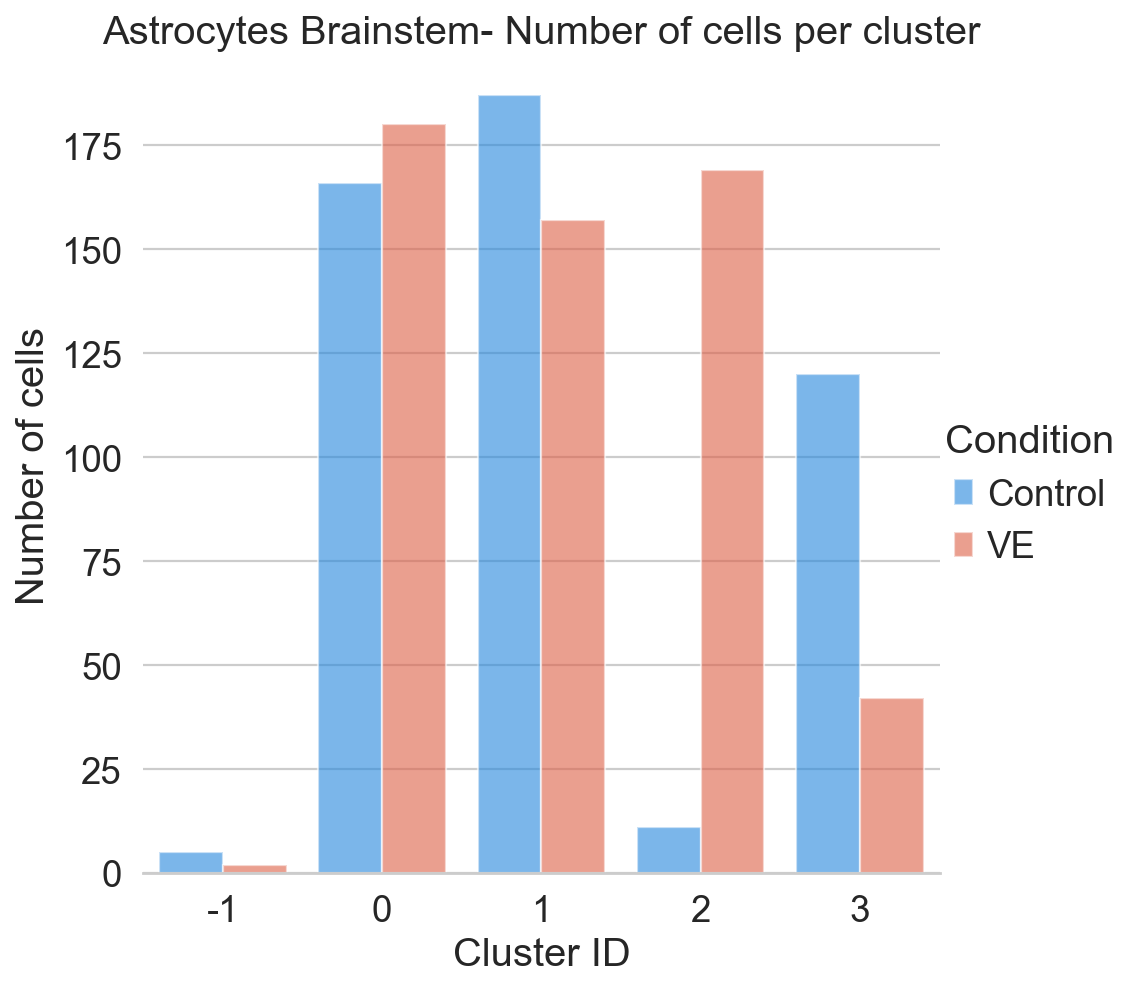

In [142]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Astrocytes Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

# Tests markers between specific clusters

## **T-test** Compare Clusters 2 (VE) Versus 0+1 Controls

In [83]:
adata_astro_BS_only_copy = adata_astro_BS_only.copy()
# For loop creating a groups for pairwise comparison
adata_astro_BS_only_copy.obs['groups'] = ['group_2VE' if int(i) in [2] and j == 'VE' else 'group_restCTRL' if int(i) in [0,1] and j == 'Control' else 'Error' for i,j in zip(adata_astro_BS_only.obs['PhenoGraph_clusters_astro_BS'],adata_astro_BS_only.obs['Condition'] )]

In [84]:
adata_astro_BS_only_copy.obs.groups.value_counts()

Error             510
group_restCTRL    353
group_2VE         169
Name: groups, dtype: int64

In [85]:
# select only cells that are in these 2 groups that I want to compare
adata_astro_BS_to_compare = adata_astro_BS_only_copy[[group in ['group_restCTRL', 'group_2VE'] for group in adata_astro_BS_only_copy.obs['groups']],].copy()
adata_astro_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


group_restCTRL    353
group_2VE         169
Name: groups, dtype: int64

... storing 'Astro_BS_subclusters' as categorical
... storing 'groups' as categorical


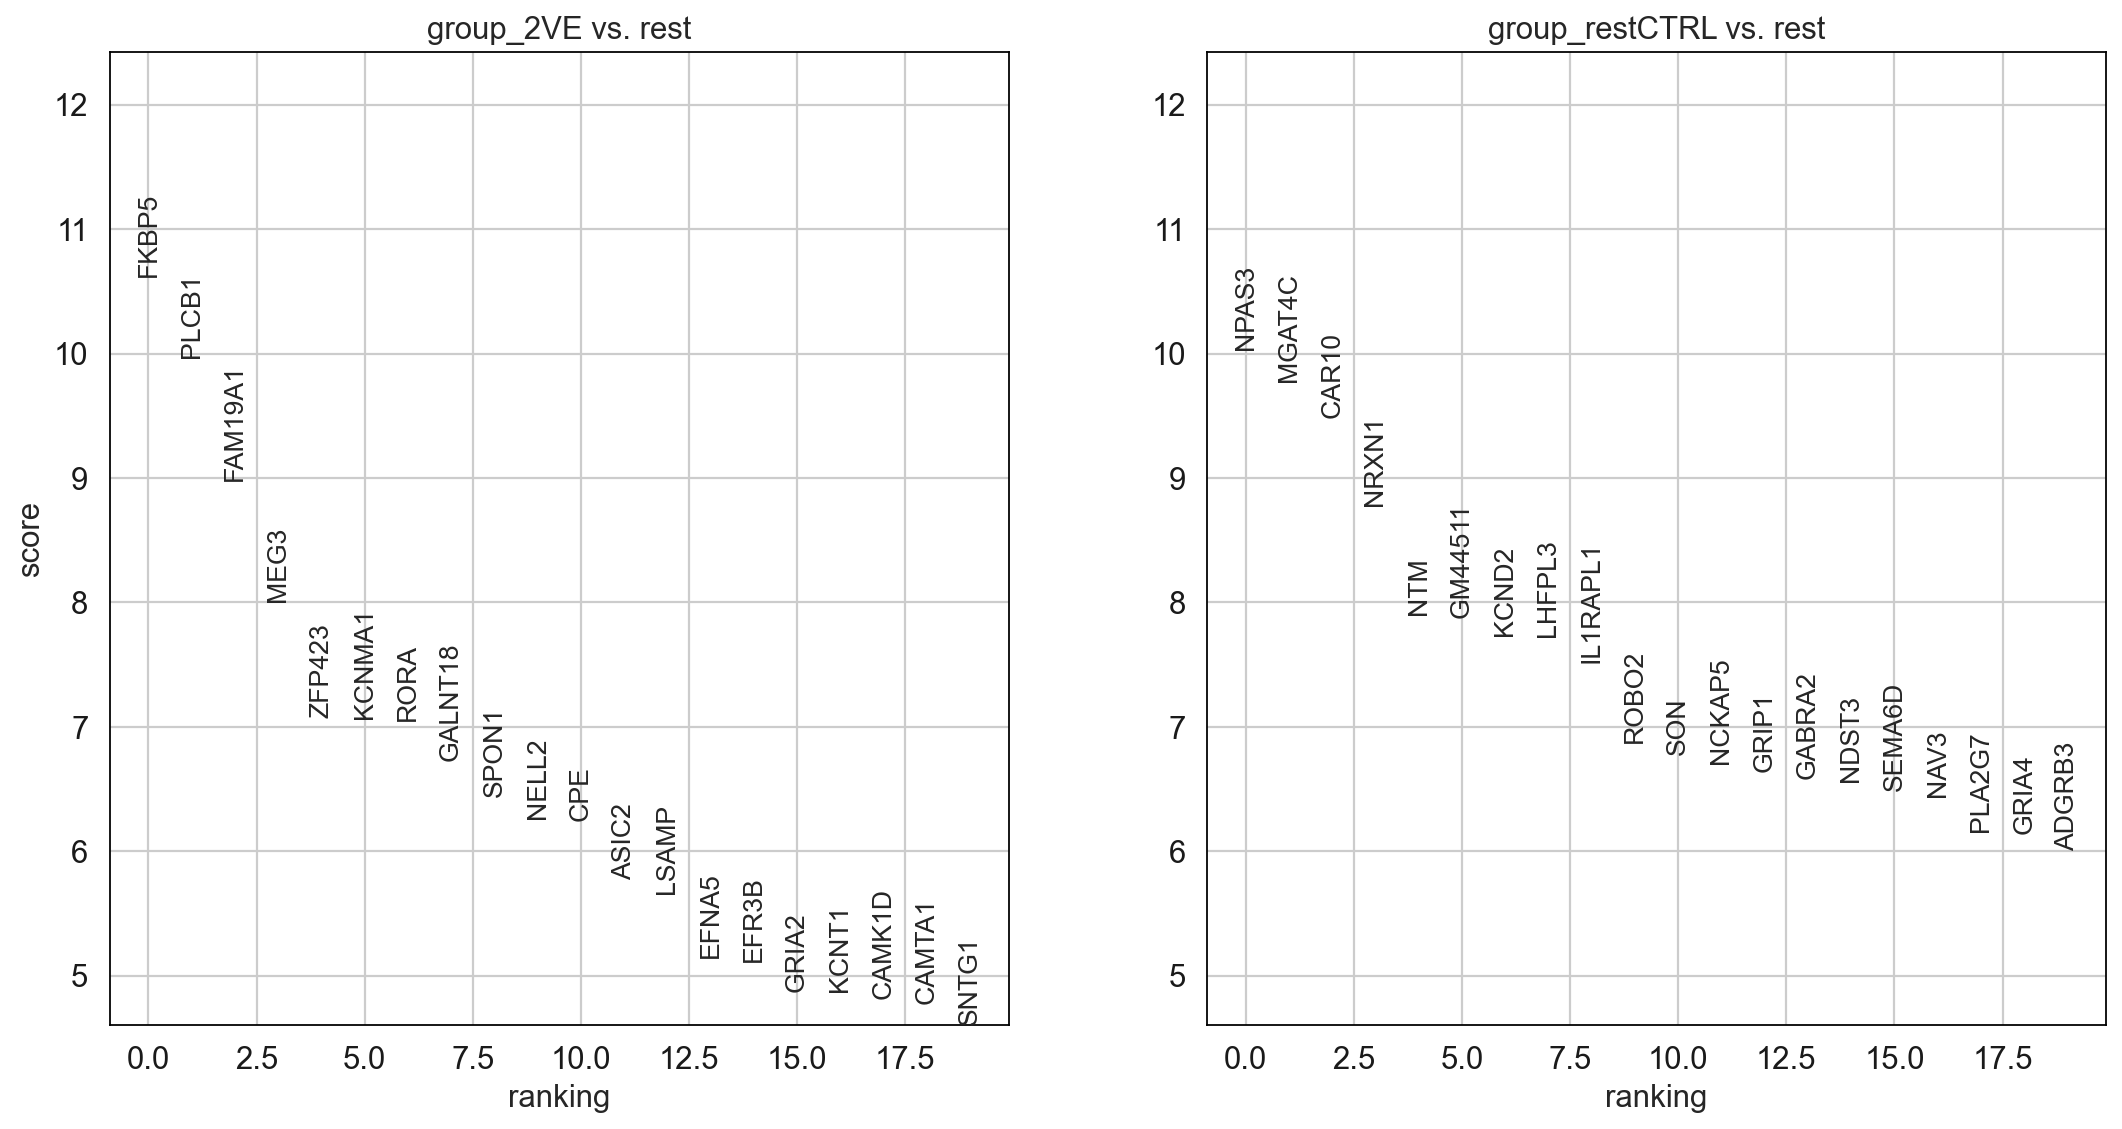

In [87]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_2VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_astro_BS_to_compare, groupby='groups', key_added="group_2VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro_BS_to_compare, key = 'group_2VE', fontsize=12)

result = adata_astro_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [92]:
pval_table = pval_table.sort_values(by= 'group_2VE_l', ascending=False)
pval_table[(pval_table.group_2VE_p < 0.05) & (pval_table.group_2VE_l > 0.5)].head(10)

group_2VE_n  group_2VE_l   group_2VE_p group_restCTRL_n  group_restCTRL_l  \
0        FKBP5     5.076255  2.846684e-22            NPAS3          1.063130   
9        NELL2     3.235796  1.633532e-07            ROBO2          2.883820   
2      FAM19A1     2.734150  5.219560e-16            CAR10          2.973437   
13       EFNA5     2.631690  6.892320e-05           GABRA2          2.469962   
4       ZFP423     2.177866  1.244440e-09              NTM          0.727847   
32      PDE10A     2.127426  2.260470e-02            PTPRT          2.264457   
7      GALNT18     2.009794  1.052646e-08           LHFPL3          2.818930   
16       KCNT1     1.725568  2.245053e-04             NAV3          1.986267   
31     FAM107A     1.638636  1.694334e-02           SLC4A4          0.455368   
5       KCNMA1     1.574546  1.250347e-09          GM44511          2.974711   

    group_restCTRL_p  
0       6.634288e-20  
9       4.410165e-09  
2       5.667012e-18  
13      2.378113e-08  
4       3.593935e-12  
32      1.324867e-04  
7       1.122869e-11  
16      5.521687e-08  
31      9.046014e-05  
5       3.926058e-12

### MAST 

In [94]:
cell_type = 'Astrocytes_Brainstem_C2'
expmat = pd.DataFrame(adata_astro_BS_to_compare.X, columns = adata_astro_BS_to_compare.var.index, index = adata_astro_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_astro_BS_to_compare.obs, columns=adata_astro_BS_to_compare.obs.columns, index = adata_astro_BS_to_compare.obs.index)
expmat.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [95]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('../DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = '../DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [158]:
# import the MAST results
mast_C2_res = pd.read_csv (filepath_or_buffer= '../DEA/Astrocytes_Brainstem_C2/MAST_DEA_Astrocytes_Brainstem_C2_RESULTS.csv')
print(mast_C2_res)

          gene             p     p.fdr.adj     logFC
0        FKBP5  1.610585e-40  1.863286e-36  2.625713
1        PLCB1  6.066046e-27  3.508905e-23  0.961991
2      FAM19A1  7.431108e-22  2.865683e-18  2.132148
3        NELL2  6.515821e-19  1.884538e-15  1.754935
4        NPAS3  9.706356e-16  2.245857e-12 -0.559747
...        ...           ...           ...       ...
11564   ZWILCH  7.378446e-01  1.000000e+00 -0.008072
11565    ZWINT  5.280006e-01  1.000000e+00 -0.157231
11566     ZXDB  7.608798e-01  1.000000e+00 -0.024620
11567      ZYX  6.618050e-01  1.000000e+00  0.046438
11568     ZZZ3  7.820459e-01  1.000000e+00 -0.100958

[11569 rows x 4 columns]


In [159]:
#filter DE results
mast_C2_res = mast_C2_res.sort_values(by='logFC', ascending=False)
mast_C2_res_sig = mast_C2_res[mast_C2_res['p.fdr.adj'] <= 0.05]
# Upregulated genes
mast_C2_res_UP = mast_C2_res[(mast_C2_res['logFC'] >=0.5) & (mast_C2_res['p.fdr.adj'] <= 0.05)]
mast_C2_res_DOWN = mast_C2_res[(mast_C2_res['logFC'] <=-0.5) & (mast_C2_res['p.fdr.adj'] <= 0.05)]
mast_C2_res_UP.head(10)

gene             p     p.fdr.adj     logFC
0     FKBP5  1.610585e-40  1.863286e-36  2.625713
2   FAM19A1  7.431108e-22  2.865683e-18  2.132148
3     NELL2  6.515821e-19  1.884538e-15  1.754935
10   ZFP423  7.461924e-13  7.847909e-10  1.536993
13  GALNT18  2.564515e-12  2.119205e-09  1.527539
15    EFNA5  2.901526e-11  2.086867e-08  1.423761
32    SNTG1  5.150314e-08  1.860207e-05  1.405724
9    KCNMA1  4.646607e-13  5.375660e-10  1.346975
26    RCAN2  1.036491e-08  4.441173e-06  1.288105
71     VAV3  1.910780e-05  3.111627e-03  1.123508

**FOR GO**

In [160]:
mast_C2_res_UP_for_GO = mast_C2_res[(mast_C2_res['p.fdr.adj'] <= 0.05) & (mast_C2_res['logFC'] >=0.05)]
mast_C2_res_DOWN_for_GO = mast_C2_res[(mast_C2_res['p.fdr.adj'] <= 0.05) & (mast_C2_res['logFC'] <=-0.05)]

In [ ]:
#mast_C2_res_UP.sort_values(by='p.fdr.adj', ascending=True).head(10)

In [198]:
#mast_C1_3_5_res_UP.to_csv(path_or_buf='/Users/fragkogs/Desktop/mast_C1_3_5_6_res_UP.csv', index=False)

### Volcano plot

In [99]:
mast_C2_res = mast_C2_res.dropna()

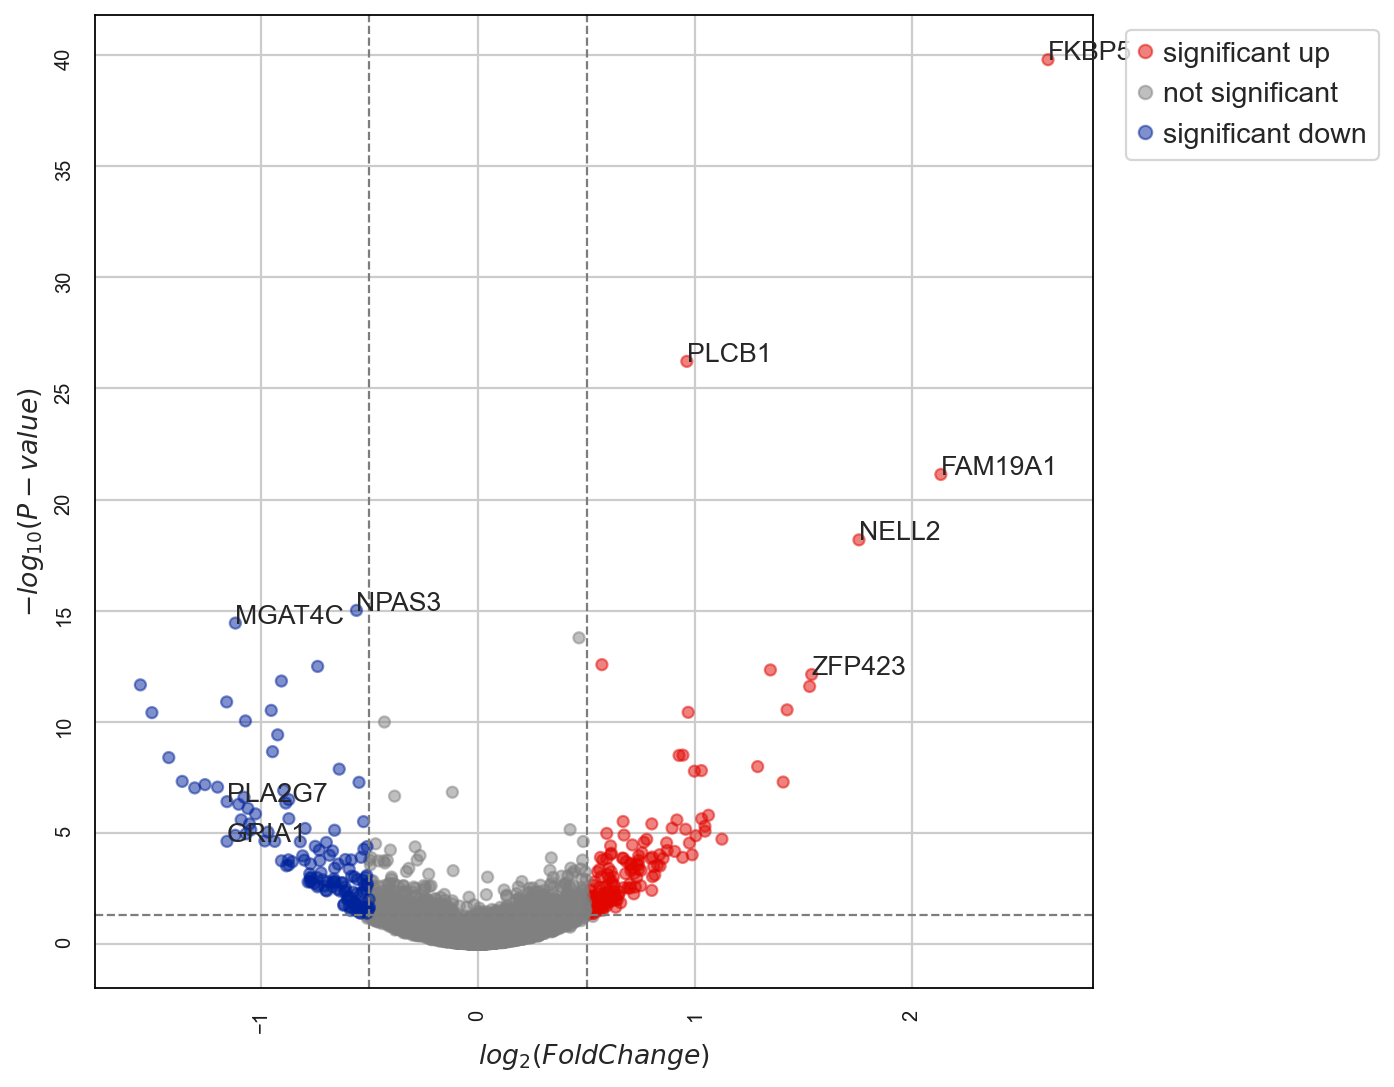

In [107]:
sc.set_figure_params(figsize=(6, 4))
from bioinfokit import analys, visuz
visuz.gene_exp.volcano(df=mast_C2_res, lfc='logFC', pv='p',show=True, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.3,1),color=("#E10600FF", "grey", "#00239CFF"), valpha=0.5, dotsize=25, geneid="gene", 
                       genenames=('FKBP5', 'NELL2', 'ZFP423','PLCB1','FAM19A1', 'NPAS3', 'MGAT4C','PLA2G7','GRIA1'),  sign_line=True, gfont = 12, dim=(8,8), axlabelfontsize = 12, lfc_thr=(0.5, 0.5))

### HEATMAP OF TOP10 UPREGULATED GENES

In [115]:
marker_genes_dict = dict()

marker_genes_dict = {'C2_UP': mast_C2_res_UP['gene'].head(20)}
marker_genes_dict
marker_genes_dict = marker_genes_dict['C2_UP'].drop(97)

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


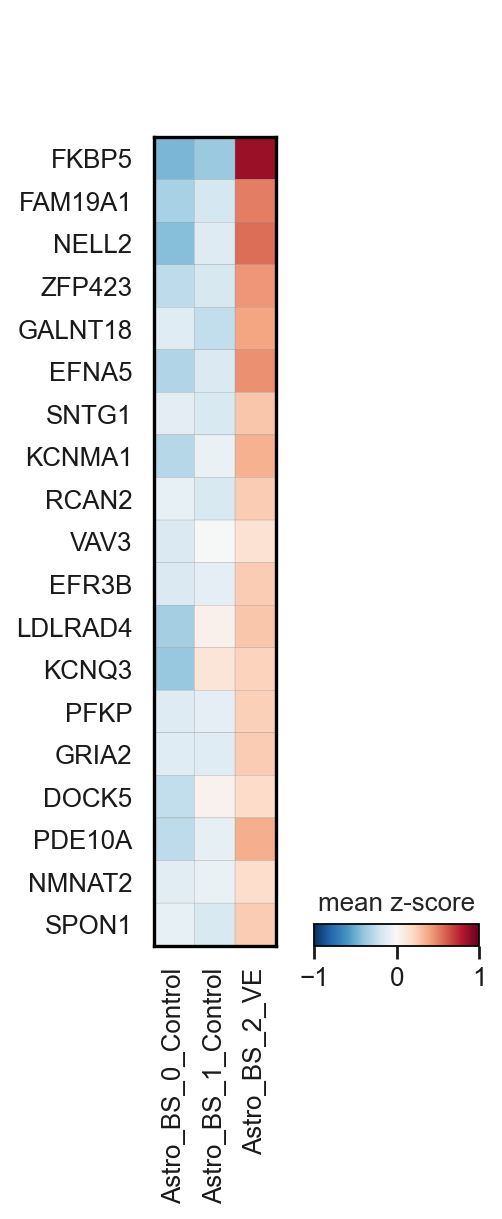

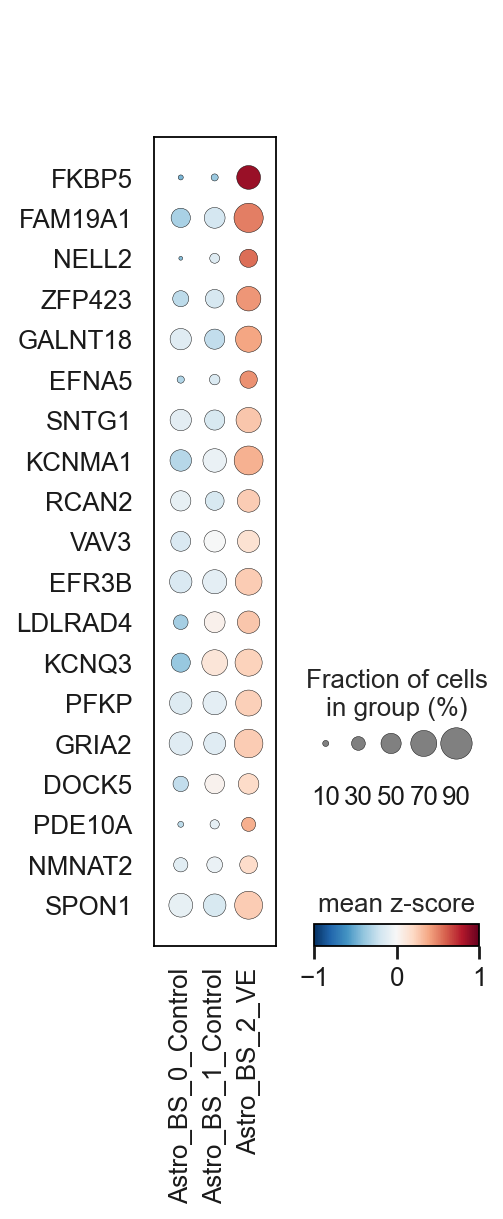

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


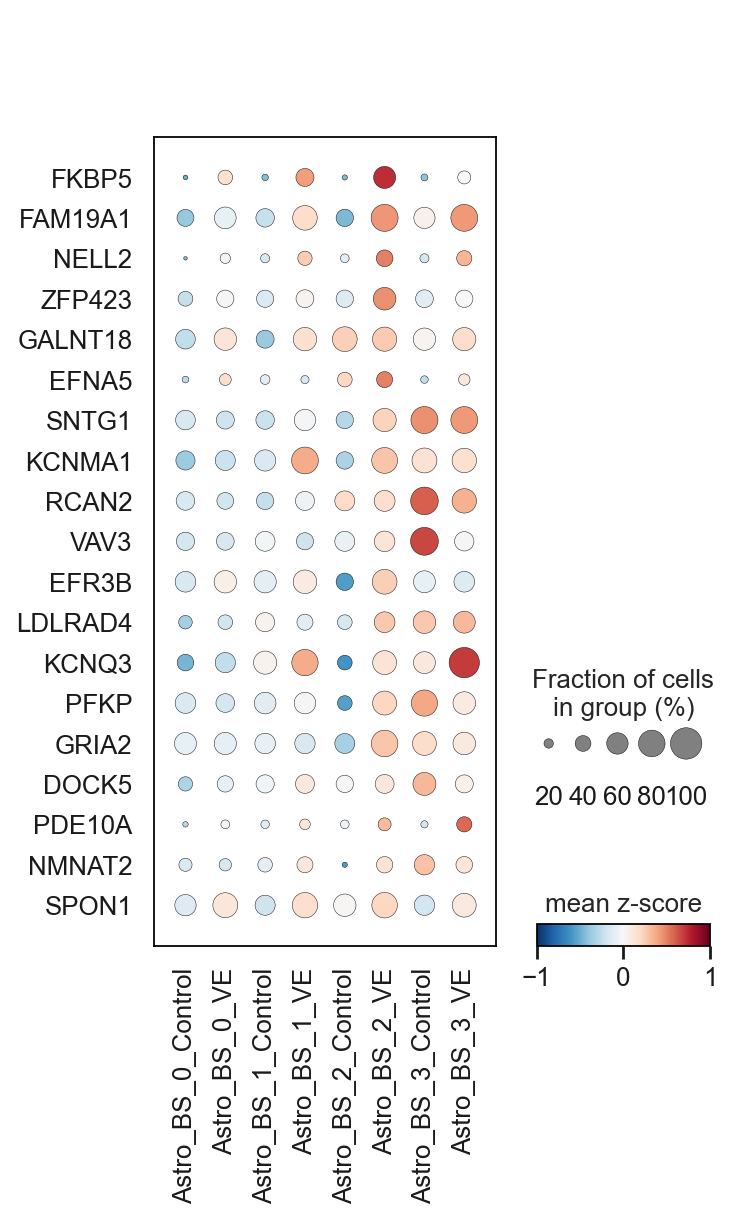

In [119]:
sc.set_figure_params(figsize=(8, 8))
adata_astro_BS_to_compare.layers['scaled'] = sc.pp.scale(adata_astro_BS_to_compare, copy=True).X
sc.pl.matrixplot(adata_astro_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS_to_compare, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS_only_copy, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Enricher

In [164]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C2_res_n_list = mast_C2_res_DOWN_for_GO.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C2_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [165]:
enr_res.results.head(20)

Gene_set                                     Term Overlap  \
0   KEGG_2019_Mouse                           Bile secretion    5/72   
1   KEGG_2019_Mouse                       Nicotine addiction    4/40   
2   KEGG_2019_Mouse                        GABAergic synapse    5/90   
3   KEGG_2019_Mouse                    Glutamatergic synapse   5/114   
4   KEGG_2019_Mouse     Retrograde endocannabinoid signaling   5/150   
5   KEGG_2019_Mouse                       Morphine addiction    4/92   
6   KEGG_2019_Mouse                   cAMP signaling pathway   5/211   
7   KEGG_2019_Mouse                   Gastric acid secretion    3/74   
8   KEGG_2019_Mouse  Proximal tubule bicarbonate reclamation    2/22   
9   KEGG_2019_Mouse                   Synaptic vesicle cycle    3/77   
10  KEGG_2019_Mouse                             Gap junction    3/86   
11  KEGG_2019_Mouse                    Circadian entrainment    3/99   
12  KEGG_2019_Mouse                     Pancreatic secretion   3/105   
13  KEGG_2019_Mouse                  Proteoglycans in cancer   4/203   
14  KEGG_2019_Mouse                   AMPK signaling pathway   3/126   
15  KEGG_2019_Mouse                   Ether lipid metabolism    2/47   
16  KEGG_2019_Mouse           Glycosaminoglycan biosynthesis    2/53   
17  KEGG_2019_Mouse                  Ovarian steroidogenesis    2/57   
18  KEGG_2019_Mouse                     Long-term depression    2/61   
19  KEGG_2019_Mouse                    Amphetamine addiction    2/68   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0   0.000012          0.001338            0                     0   18.991581   
1   0.000022          0.001338            0                     0   27.962025   
2   0.000036          0.001441            0                     0   14.956259   
3   0.000112          0.003339            0                     0   11.649024   
4   0.000403          0.009583            0                     0    8.740937   
5   0.000584          0.011578            0                     0   11.409091   
6   0.001858          0.031584            0                     0    6.133620   
7   0.003614          0.048097            0                     0   10.482042   
8   0.003724          0.048097            0                     0   24.564198   
9   0.004042          0.048097            0                     0   10.055574   
10  0.005506          0.059561            0                     0    8.961145   
11  0.008120          0.080519            0                     0    7.742578   
12  0.009534          0.086264            0                     0    7.284926   
13  0.010149          0.086264            0                     0    5.016984   
14  0.015560          0.121231            0                     0    6.034756   
15  0.016300          0.121231            0                     0   10.903704   
16  0.020449          0.143141            0                     0    9.618010   
17  0.023433          0.154919            0                     0    8.916723   
18  0.026585          0.166504            0                     0    8.310525   
19  0.032484          0.191344            0                     0    7.426487   

    Combined Score                                Genes  
0       214.782197       AQP4;ATP1A2;ADCY2;HMGCR;SLC4A4  
1       299.265226            GRIA1;GABRA2;GABRB1;GRIA4  
2       152.899598  GABRA2;GABRB1;SLC38A1;ADCY2;SLC6A11  
3       105.945393     GRIA1;SLC38A1;SLC1A3;ADCY2;GRIA4  
4        68.331720      GABRA2;GRIA1;GABRB1;ADCY2;GRIA4  
5        84.952554            GABRA2;GABRB1;PDE4D;ADCY2  
6        38.570180       GRIA1;PDE4D;ATP1A2;ADCY2;GRIA4  
7        58.940633                  KCNJ10;ATP1A2;ADCY2  
8       137.384761                        ATP1A2;SLC4A4  
9        55.417075                UNC13C;SLC1A3;SLC6A11  
10       46.615706                    TUBB2B;GJA1;ADCY2  
11       37.268708                    GRIA1;ADCY2;GRIA4  
12       33.896192                  ATP1A2

In [163]:
gseapy.barplot(enr_res.res2d,title='KEGG_2019_Mouse',top_term=10,color='green',figsize=(4,4))

'Warning: No enrich terms using library KEGG_2019_Mouse when cutoff = 0.05'

# Whole Brain analysis

In [22]:
WB_up = df = pd.read_csv(filepath_or_buffer= '../WholeBrain_Data/Whole_brain_UP.txt', delimiter = "\t")
print(WB_up)

      GeneName
0          FGR
1        ITGAL
2         SCIN
3         SELE
4          CD4
..         ...
313      FCGBP
314     PIK3R6
315  LINC00706
316  PACRG-AS1
317    SLC35D2

[318 rows x 1 columns]


In [23]:
WB_down = df = pd.read_csv(filepath_or_buffer= '../WholeBrain_Data/Whole_brain_DOWN.txt', delimiter = "\t")
print(WB_down)

    GeneName
0        NRK
1    PPP1R17
2     CLEC4G
3      CALB1
4       COMP
..       ...
95    FRMPD2
96      VAX2
97      ENO3
98  TP53AIP1
99   TMEM63C

[100 rows x 1 columns]


In [24]:
inter_up = adata_astro_BS[:, adata_astro_BS.var_names.isin(WB_up['GeneName'])].copy()
inter_down = adata_astro_BS[:, adata_astro_BS.var_names.isin(WB_down['GeneName'])].copy()

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [27]:
WB_up_dict = dict()

WB_up_dict = {'WB_up': inter_up.var_names[1:50]}
WB_up_dict

{'WB_up': Index(['KCNQ1', 'FLI1', 'PLEK', 'DOCK2', 'PRKCH', 'ELOVL7', 'ERBIN', 'OSMR',
        'FKBP5', 'LAMA3', 'CSF1R', 'PAPSS2', 'ITGB1', 'CASP1', 'APBB1IP',
        'NFATC2', 'MECOM', 'TLR2', 'DAPP1', 'LAPTM5', 'ABCG2', 'STARD8',
        'ADCY7', 'SLC37A2', 'PLSCR1', 'TGFBR2', 'GAB3', 'ABCC4', 'SLC35D2',
        'LPAR6', 'PLCG2', 'P2RY12', 'SMAD6', 'C1QC', 'C1QB', 'CTSS', 'ADGRG6',
        'RUNX2', 'NLRC4', 'LAT2', 'DOCK8', 'CX3CR1', 'ADARB2', 'LAIR1',
        'PLA2G4A', 'SLC14A1', 'BLNK', 'TMIGD3', 'TLR5'],
       dtype='object')}

In [ ]:
sc.set_figure_params(figsize=(8, 8))
inter_up.layers['scaled'] = sc.pp.scale(inter_up, copy=True).X
sc.pl.matrixplot(inter_up, WB_up_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)


In [30]:
# import the MAST results
mast_astro_BS = pd.read_csv (filepath_or_buffer= '../DEA/Astrocytes_Brainstem/MAST_DEA_Astrocytes_RESULTS.csv')
print(mast_astro_BS)
#filter DE results
mast_astro_BS = mast_astro_BS.sort_values(by='logFC', ascending=False)
mast_astro_BS_sig = mast_astro_BS[mast_astro_BS['p.fdr.adj'] <= 0.05]

          gene             p     p.fdr.adj     logFC
0        FKBP5  2.253986e-52  2.607637e-48  1.921319
1        NPAS3  8.194024e-30  4.739833e-26 -0.554146
2          SON  1.784910e-29  6.883207e-26 -0.879372
3          NTM  5.221607e-27  1.510219e-23 -0.503744
4       MGAT4C  4.579159e-20  1.059526e-16 -0.953608
...        ...           ...           ...       ...
11564     IAH1  9.996181e-01  9.999639e-01 -0.001062
11565    EIF5B  9.997989e-01  9.999718e-01  0.001138
11566  PLA2G4A  9.997635e-01  9.999718e-01  0.000163
11567     CAST  1.000000e+00  1.000000e+00 -0.000250
11568  EIF2AK2  1.000000e+00  1.000000e+00 -0.001404

[11569 rows x 4 columns]


**Upregulated**

In [31]:
mast_astro_BS_sig['gene'].isin(inter_up.var_names).value_counts()

False    397
True       3
Name: gene, dtype: int64

In [32]:
mast_astro_BS_sig[mast_astro_BS_sig['gene'].isin(inter_up.var_names)].head(10)

gene             p     p.fdr.adj     logFC
0     FKBP5  2.253986e-52  2.607637e-48  1.921319
330  ACAD11  8.850573e-04  3.089568e-02  0.169921
9    LHFPL3  2.120786e-19  2.453538e-16 -1.387237

**Downregulated**

In [33]:
mast_astro_BS_sig['gene'].isin(inter_down.var_names).value_counts() 

False    397
True       3
Name: gene, dtype: int64

In [34]:
mast_astro_BS_sig[mast_astro_BS_sig['gene'].isin(inter_down.var_names)].head(10)

gene             p     p.fdr.adj     logFC
103  GRID2  3.901967e-06  4.340563e-04 -0.339056
124   NNAT  1.241296e-05  1.148844e-03 -0.543048
23    LGR6  7.646261e-12  3.822921e-09 -0.683534

# A1 Activated astrocytes analysis

In [ ]:
mast_astro_BS

In [14]:
marker_genes_dict = dict()

marker_genes_dict = {'A1_markers': ['C3', NO
'SERPING1', ok
'LIGP1', NO
    'GGTA1', ok
'PSMB8', NO
'SRGN', NO 
'AMIGO2' ok ]}

In [15]:
adata_astro_BS_only.layers['scaled'] = sc.pp.scale(adata_astro_BS_only, copy=True).X
sc.pl.matrixplot(adata_astro_BS_only, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS_only, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_BS_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)


/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Astro_BS_subclusters' as categorical


KeyError: "Values ['C3', 'SERPING', 'IIGP1', 'PSMB8', 'SRGN'], from ['C3', 'SERPING', 'IIGP1', 'GGTA1', 'PSMB8', 'SRGN', 'AMIGO2'], are not valid obs/ var names or indices."